<a href="https://colab.research.google.com/github/elenaajayi/Computer-Vision-Fundamentals---CUS-754/blob/main/Capstone_Project/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from IPython.display import HTML, Javascript

# Auto-click “CONNECT” every 60 s to prevent idle timeout
js = """
function ClickConnect(){
  console.log("Auto-clicking connect");
  document.querySelector("colab-toolbar-button#connect").click();
}
setInterval(ClickConnect, 60000);
"""
display(Javascript(js))


<IPython.core.display.Javascript object>

# Skin‑Lesion Capstone

▶︎ **Purpose**  
A streamlined, reproducible version with:

* single install/import block  
* deterministic seeding  
* refactored data pipelines  
* evaluation helpers (confusion matrix, qualitative montage)  
* figure‑export snippets for the FLAIRS paper  

---

In [ ]:
#import libraries
import os
from pathlib import Path
import pandas as pd
from PIL import Image
import numpy as np
import cv2
from skimage.filters import threshold_otsu
from skimage import morphology

In [ ]:
from google.colab import drive
drive.mount('/content/drive') # Mount to the existing '/content/drive' directory

Mounted at /content/drive


In [ ]:
# point to your mounted drive folder in Colab
base_dir = Path('/content/drive/MyDrive/ProjectMaterials/dataset')

#defining the exact image & mask subfolders
images_dir = base_dir / 'HAM10000_images'
masks_dir  = (base_dir / 'HAM10000_masks' / 'HAM10000_segmentations_lesion_tschandl')

#loading metadata
metadata_df = pd.read_csv(base_dir / 'HAM10000_metadata.csv')


In [ ]:
!pip install opencv-python scikit-image tensorflow matplotlib pandas


In [ ]:
meta_path = base_dir / 'HAM10000_metadata.csv'
meta_data_df = pd.read_csv(meta_path)

In [ ]:
 #– images are named e.g. ISIC_0000000.jpg
#    – masks are named e.g. ISIC_0000000_segmentation.png
meta_data_df['image_path'] = meta_data_df['image_id'].apply(lambda x: str(images_dir / f"{x}.jpg"))
meta_data_df['mask_path']  = meta_data_df['image_id'].apply(lambda x: str(masks_dir  / f"{x}_segmentation.png"))


In [ ]:
#none should be missing; if any are missing,  i made a typo
# didn’t unzip something in the right place.
missing_imgs = [p for p in meta_data_df['image_path'] if not Path(p).exists()]
missing_masks = [p for p in meta_data_df['mask_path'] if not Path(p).exists()]

print(f"Total records: {len(meta_data_df)}")
print(f"Images missing: {len(missing_imgs)}")
print(f"Masks  missing: {len(missing_masks)}")


assert not missing_imgs,  "Some image files are missing!"
assert not missing_masks, "Some mask files are missing!"


Total records: 10015
Images missing: 0
Masks  missing: 0


In [ ]:
idx = 0
img = np.array(Image.open(meta_data_df.loc[0, 'image_path']))
true_mask = np.array(Image.open(meta_data_df.loc[0, 'mask_path']))
print(f"Original shapes: {img.shape} (H×W×3), {true_mask.shape} (H×W)")
print(" True mask shape:", true_mask.shape, "(H×W)")


Original shapes: (450, 600, 3) (H×W×3), (450, 600) (H×W)
 True mask shape: (450, 600) (H×W)


In [ ]:
def segment_lesion_hsv_otsu(image: np.ndarray) -> np.ndarray:
    #convert to HSV
    hsv      = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    sat      = hsv[:, :, 1]
    #otsu threshold on saturaion
    thresh   = threshold_otsu(sat)
    raw_mask = sat > thresh
    #clean up objects and holes; Returns a binary mask (uint8, values 0 or 1).
    clean    = morphology.remove_small_objects(raw_mask, min_size=500)
    clean    = morphology.remove_small_holes(clean, area_threshold=500)
    return clean.astype(np.uint8)

In [ ]:
# load them in a loop
# load first image+mask pair
img = np.array(Image.open(meta_data_df .loc[0, 'image_path']))
mask = np.array(Image.open(meta_data_df .loc[0, 'mask_path']))
print("Original shapes:", img.shape, mask.shape)


Original shapes: (450, 600, 3) (450, 600)


In [ ]:
#try auto segmentation on our example
auto_mask  = segment_lesion_hsv_otsu(img)
print("Auto-mask shape:", auto_mask.shape)


Auto-mask shape: (450, 600)


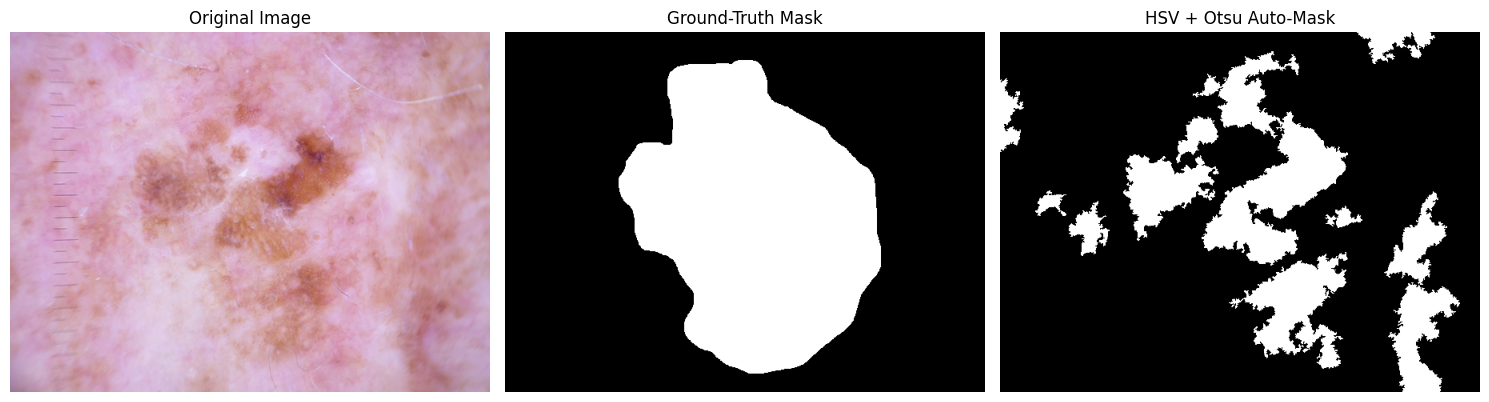

In [ ]:
import matplotlib.pyplot as plt

#plot the results to see how close we got
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(img)
axes[0].set_title("Original Image")
axes[0].axis('off')

axes[1].imshow(true_mask, cmap='gray')
axes[1].set_title("Ground-Truth Mask")
axes[1].axis('off')

axes[2].imshow(auto_mask, cmap='gray')
axes[2].set_title("HSV + Otsu Auto-Mask")
axes[2].axis('off')

plt.tight_layout()
plt.show()


#ground truth mask icomes from PNG files in the HAM10000_segmentations_lesion_tschandl folder

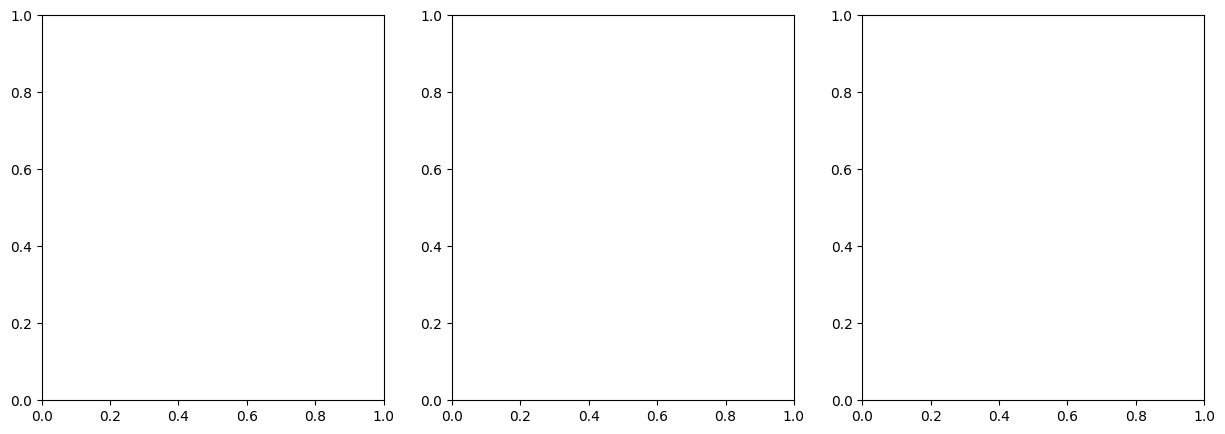

In [ ]:
#apply to image
masked_img = img.copy()
masked_img[auto_mask == 0] = 0
# now let’s look at them side-by-side
fig, axes = plt.subplots(1, 3, figsize=(15, 5))


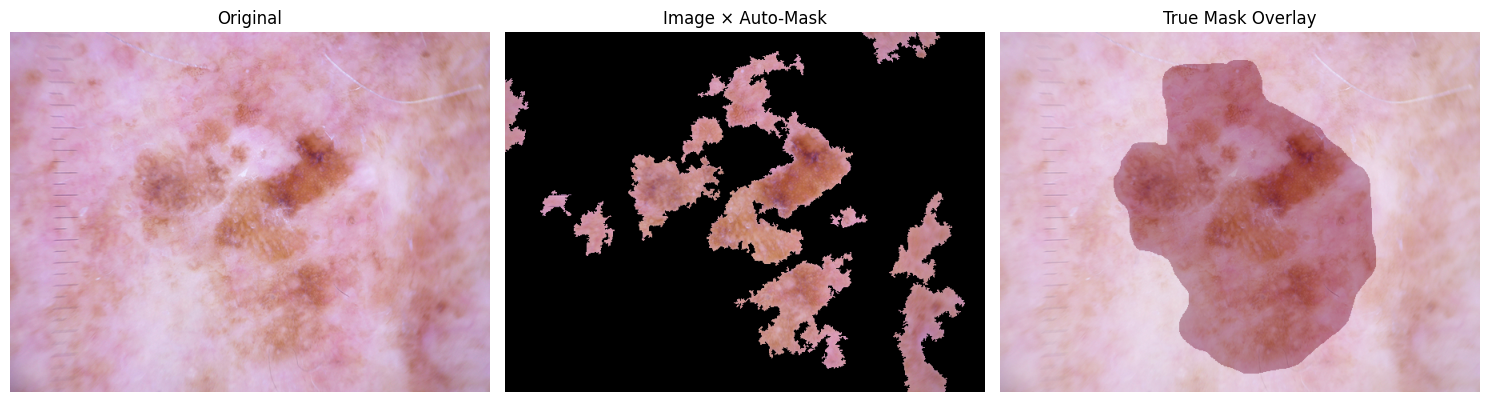

In [ ]:
# compare original, masked, and overlay of true mask
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(img)
axes[0].set_title("Original")
axes[0].axis('off')

axes[1].imshow(masked_img)
axes[1].set_title("Image × Auto-Mask")
axes[1].axis('off')

axes[2].imshow(img)
axes[2].imshow(true_mask, cmap='Reds', alpha=0.3)
axes[2].set_title("True Mask Overlay")
axes[2].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
#we want to make sure the dx string labels are encoded as integers

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
meta_data_df['dx'] = label_encoder.fit_transform(meta_data_df['dx'])
print("classes:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))


#want a uniform size and to naormalize
#resizing everything tob 224x224 and scale pixels to [0,1]

img_size = (224, 224)

#fucntion to preprocess
def preprocess_row(row):
  #let's load the img and the mask...
  img = Image.open(row['image_path']).convert('RGB')
  mask = Image.open(row['mask_path']).convert('L')

  #convert img to numpy array
  img = np.array(img)
  mask = np.array(mask)

  #resize - for cv2 wxh are resized
  img = cv2.resize(img, img_size)
  mask = cv2.resize(mask, img_size)

  #normalize images and we will binarize mask

  img = img.astype(np.float32) / 255.0
  mask = (mask > 127).astype(np.float32) # encode the. non-bl;ack sections to 1.0

  #we converted the dx columns to integers, so pull it out
  label = float(row['dx'])

  return img, mask, label

  #lets see how it pans out on the first row....
  sample_img, sample_mask, sample_label = preprocess_row(meta_data_df.iloc[0])
  print("→ img:",  sample_img.shape, sample_img.min(), sample_img.max())
  print("→ mask:", sample_mask.shape, np.unique(sample_mask))
  print("→ lbl:",  sample_lbl)

  #Ground-truth (GT) → human annotation, saved as PNGs.
  #Auto-mask → algorithmic estimate (HSV channel + Otsu threshold + morphological cleanup).


classes: {'akiec': np.int64(0), 'bcc': np.int64(1), 'bkl': np.int64(2), 'df': np.int64(3), 'mel': np.int64(4), 'nv': np.int64(5), 'vasc': np.int64(6)}


In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit(meta_data_df['dx'])

mapping = {cls: int(idx)
           for cls, idx in zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))}
print("Class → int mapping:", mapping)

#2) store df as a native Python int column
meta_data_df['dx_int'] = meta_data_df['dx'].map(mapping)


Class → int mapping: {np.int64(0): 0, np.int64(1): 1, np.int64(2): 2, np.int64(3): 3, np.int64(4): 4, np.int64(5): 5, np.int64(6): 6}


In [ ]:
from sklearn.model_selection import train_test_split

# 80% train, then split the 20% leftover into 10% val / 10% test

#train_df = 80% of the rows (your training set).
#temp_df = gets the remaining 0% this will be split into validation set and test set

train_df, temp_df = train_test_split(
    meta_data_df,
    test_size=0.2,
    stratify=meta_data_df['dx_int'],
    random_state=42
)


#val_df has half of temp_df which is 10% of the original set
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df['dx_int'],
    random_state=42,
)

In [ ]:
import tensorflow as tf
# enable XLA JIT (fuse small operations into larger kernels)
tf.config.optimizer.set_jit(True)

# mixed-precision on modern GPUs (fp16 where safe, fp32 master weights)
# import policy from tf.keras instead of tensorflow.keras.mixed_precision -> deviated from using mirror strat approach given i have colab pro
from tensorflow import keras
keras.mixed_precision.set_global_policy('mixed_float16')

#we are setting hyperparameteres here...
img_size   = (224, 224)
batch_size = 32
autotune   = tf.data.AUTOTUNE



In [ ]:

# we are going to create a helper function to preprocess a single (path, label) pair
def load_and_preprocess(path, label):
  #let’s read the jpeg file
  img = tf.io.read_file(path)
  #decode the jpeg file into a tensor
  img = tf.image.decode_jpeg(img, channels=3)

  #let’s resize to our target...
  img = tf.image.resize(img, img_size)
  #let’s normalize the images to [0,1]
  img = img / 255.0
  return img, label

# lets turn the df into a tf.data.Dataset
def make_dataset(df: pd.DataFrame, shuffle=True):
  ds = tf.data.Dataset.from_tensor_slices((
      df['image_path'].values,
      df['dx_int'].values         # these are the integer-encoded labels we did earlier
  ))

  ds = ds.cache()  # <-- cache the decoded & resized images (RAM or local disk)
  ds = ds.map(load_and_preprocess, num_parallel_calls=autotune)
  if shuffle:
    ds = ds.shuffle(buffer_size=len(df))
  return ds.batch(batch_size).prefetch(autotune)



In [ ]:

# building the 3 splits :)
train_ds = make_dataset(train_df, shuffle=True)
val_ds   = make_dataset(val_df, shuffle=False)
test_ds  = make_dataset(test_df, shuffle=False)



In [37]:
import os
import tensorflow as tf

#exp setup
scratch_dir = "cnn_scratch_ham10000"
ckpt_dir    = os.path.join(scratch_dir, "checkpoints")
os.makedirs(ckpt_dir, exist_ok=True)

callbacks = [
    # Save only the best weights (based on val_loss)
    tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(ckpt_dir, "best.weights.h5"),
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=True,
        verbose=1
    ),
    # Log per-epoch metrics to CSV
    tf.keras.callbacks.CSVLogger(
        os.path.join(scratch_dir, "training_log.csv"),
        append=False
    ),
    # Reduce LR when a plateau in val_loss is hit
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=10,
        verbose=1
    ),
    # Note: EarlyStopping is omitted so we train all 50 epochs
]

#light data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

def augment(img, label):
    return data_augmentation(img), label

train_s = train_ds.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
val_s   = val_ds   # no augmentation on val/test
test_s  = test_ds

# build & compile
n_classes = len(label_encoder.classes_)

inputs = tf.keras.Input(shape=(224, 224, 3))
x = tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu")(inputs)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu")(x)
x = tf.keras.layers.MaxPooling2D()(x)

x = tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu")(x)
x = tf.keras.layers.MaxPooling2D()(x)

x = tf.keras.layers.Conv2D(128, 3, padding="same", activation="relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D()(x)

x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(256, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(n_classes, activation="softmax")(x)

scratch_model = tf.keras.Model(inputs, outputs, name="cnn_scratch")
scratch_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)
scratch_model.summary()

#train full 50 epochs
history_s = scratch_model.fit(
    train_s,
    validation_data=val_s,
    epochs=50,
    callbacks=callbacks
)

#load best weights and evaluate
scratch_model.load_weights(os.path.join(ckpt_dir, "best.weights.h5"))
loss_s, acc_s = scratch_model.evaluate(test_s)
print(f"[Scratch CNN] Best-on-val test accuracy: {acc_s:.4f}")


Model: "cnn_scratch"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_1 (Cast)                   │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,832,487 (98.54 MB)

 Trainable params: 25,832,039 (98.54 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.4734 - loss: 6.4571
Epoch 1: val_loss improved from inf to 5.34586, saving model to cnn_scratch_ham10000/checkpoints/best.weights.h5
251/251 ━━━━━━━━━━━━━━━━━━━━ 80s 165ms/step - accuracy: 0.4739 - loss: 6.4557 - val_accuracy: 0.6683 - val_loss: 5.3459 - learning_rate: 0.0010
Epoch 2/50
249/251 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.6737 - loss: 5.2554
Epoch 2: val_loss improved from 5.34586 to 5.32976, saving model to cnn_scratch_ham10000/checkpoints/best.weights.h5
251/251 ━━━━━━━━━━━━━━━━━━━━ 32s 112ms/step - accuracy: 0.6737 - loss: 5.2564 - val_accuracy: 0.6693 - val_loss: 5.3298 - learning_rate: 0.0010
Epoch 3/50
249/251 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.6718 - loss: 5.2892
Epoch 3: val_loss did not improve from 5.32976
251/251 ━━━━━━━━━━━━━━━━━━━━ 30s 106ms/step - accuracy: 0.6718 - loss: 5.2898 - val_accuracy: 0.6693 - val_loss: 5.3298 - learning_rate: 0.0010
Epoch 4/50
250/251 ━━━━━━━━

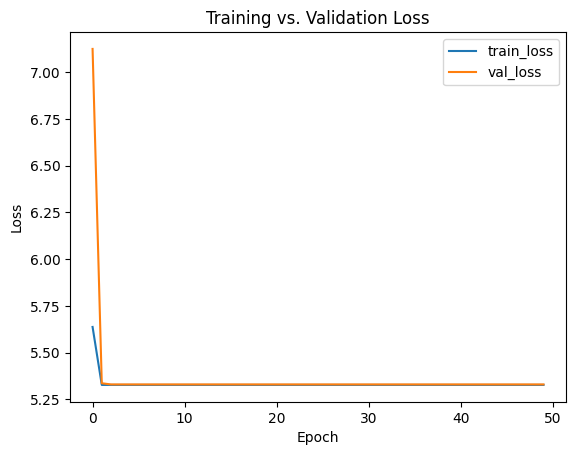

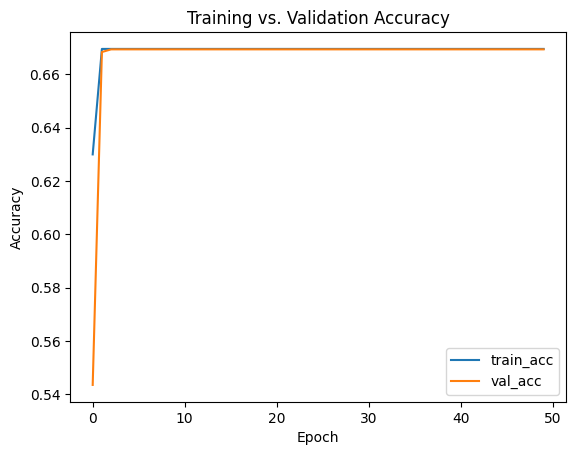

In [ ]:
#lets see if i am overfittong

import matplotlib.pyplot as plt

# Loss curve
plt.figure()
plt.plot(history_s.history['loss'], label='train_loss')
plt.plot(history_s.history['val_loss'], label='val_loss')
plt.title('Training vs. Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Accuracy curve
plt.figure()
plt.plot(history_s.history['accuracy'], label='train_acc')
plt.plot(history_s.history['val_accuracy'], label='val_acc')
plt.title('Training vs. Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


Model: "cnn_scratch_step2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_5 (Cast)                   │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 28, 28, 256)    │         1,02

 Total params: 1,243,687 (4.74 MB)

 Trainable params: 1,241,767 (4.74 MB)

 Non-trainable params: 1,920 (7.50 KB)

Epoch 1/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.6165 - loss: 1.1424
Epoch 1: val_loss improved from inf to 1.31324, saving model to cnn_scratch_ham10000_step2/checkpoints/best.weights.h5
251/251 ━━━━━━━━━━━━━━━━━━━━ 57s 106ms/step - accuracy: 0.6166 - loss: 1.1418 - val_accuracy: 0.5934 - val_loss: 1.3132
Epoch 2/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6684 - loss: 0.9305
Epoch 2: val_loss improved from 1.31324 to 1.16859, saving model to cnn_scratch_ham10000_step2/checkpoints/best.weights.h5
251/251 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.6684 - loss: 0.9304 - val_accuracy: 0.6713 - val_loss: 1.1686
Epoch 3/20
249/251 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6652 - loss: 0.9040
Epoch 3: val_loss did not improve from 1.16859
251/251 ━━━━━━━━━━━━━━━━━━━━ 24s 44ms/step - accuracy: 0.6653 - loss: 0.9038 - val_accuracy: 0.6623 - val_loss: 4.9297
Epoch 4/20
249/251 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6890 - loss: 0.8552
Epoch

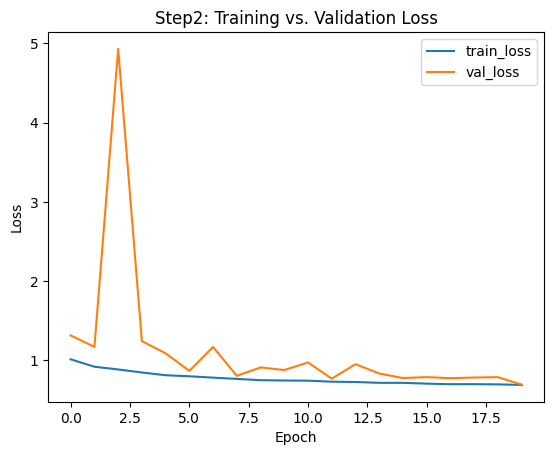

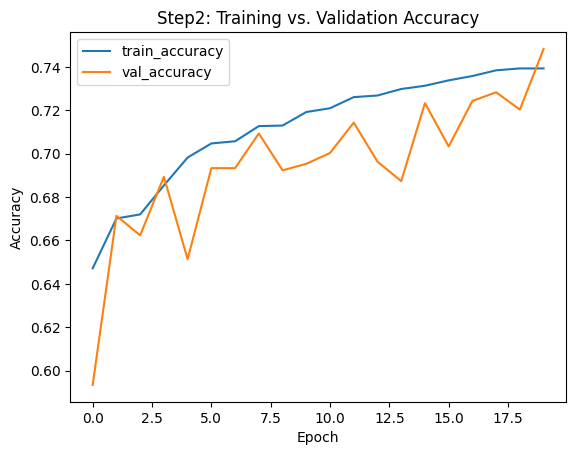

In [ ]:

# Immediate next step:
#Simplify augmentation: only flips and small rotations.
#Increase model capacity: add an extra Conv–BN–Conv–BN–MaxPool block with 256 filters.
#Retrain for 20 epochs and re-plot to confirm sustained learning.

import os
import tensorflow as tf
import matplotlib.pyplot as plt

#setup directories & callbacks
step2_dir = "cnn_scratch_ham10000_step2"
ckpt2_dir = os.path.join(step2_dir, "checkpoints")
os.makedirs(ckpt2_dir, exist_ok=True)

callbacks2 = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(ckpt2_dir, "best.weights.h5"),
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=True,
        verbose=1
    ),
    tf.keras.callbacks.CSVLogger(
        os.path.join(step2_dir, "training_log.csv"),
        append=False
    )
]

# simplified augmentation (flip + small rotation)
augment2 = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
])

def augment_fn(img, label):
    return augment2(img), label

train_aug2 = train_ds.map(augment_fn, num_parallel_calls=tf.data.AUTOTUNE)
val_noaug  = val_ds
test_noaug = test_ds

# 3) Build a deeper CNN with an extra 256-filter block
n_classes = len(label_encoder.classes_)

inp = tf.keras.Input(shape=(224, 224, 3))
x = inp

# original conv blocks
for filters in [32, 64, 128]:
    x = tf.keras.layers.Conv2D(filters, 3, padding="same", activation="relu")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(filters, 3, padding="same", activation="relu")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Dropout(0.2)(x)

# extra block with 256 filters
x = tf.keras.layers.Conv2D(256, 3, padding="same", activation="relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Conv2D(256, 3, padding="same", activation="relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)

# head
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(256, activation="relu")(x)
x = tf.keras.layers.Dropout(0.3)(x)
out = tf.keras.layers.Dense(n_classes, activation="softmax")(x)

model_step2 = tf.keras.Model(inp, out, name="cnn_scratch_step2")
model_step2.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)
model_step2.summary()

# 4) Train for 20 epochs
history2 = model_step2.fit(
    train_aug2,
    validation_data=val_noaug,
    epochs=20,
    callbacks=callbacks2
)

# 5) Restore best weights & evaluate
model_step2.load_weights(os.path.join(ckpt2_dir, "best.weights.h5"))
loss2, acc2 = model_step2.evaluate(test_noaug)
print(f"[Step2 CNN] Best-on-val test accuracy: {acc2:.4f}")

# 6) Plot new learning curves
plt.figure()
plt.plot(history2.history['loss'], label='train_loss')
plt.plot(history2.history['val_loss'], label='val_loss')
plt.title('Step2: Training vs. Validation Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.show()

plt.figure()
plt.plot(history2.history['accuracy'], label='train_accuracy')
plt.plot(history2.history['val_accuracy'], label='val_accuracy')
plt.title('Step2: Training vs. Validation Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.show()


In [ ]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt

# Builder func for  original Step 1 CNN
def build_scratch_model(n_classes):
    inp = tf.keras.Input((224,224,3), name="input_layer")
    # Block 1
    x = tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu")(inp)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu")(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    # Block 2
    x = tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu")(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    # Block 3
    x = tf.keras.layers.Conv2D(128, 3, padding="same", activation="relu")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    # Head
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(256, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    out = tf.keras.layers.Dense(n_classes, activation="softmax")(x)

    model = tf.keras.Model(inputs=inp, outputs=out, name="cnn_scratch")
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model


=== Pipeline: flip_rotate ===


Model: "cnn_scratch"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_1 (Cast)                   │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,832,487 (98.54 MB)

 Trainable params: 25,832,039 (98.54 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.6178 - loss: 5.0902
Epoch 1: val_loss improved from inf to 15.92101, saving model to scratch_aug_flip_rotate/checkpoints/best.weights.h5
251/251 ━━━━━━━━━━━━━━━━━━━━ 112s 361ms/step - accuracy: 0.6180 - loss: 5.0910 - val_accuracy: 0.0120 - val_loss: 15.9210 - learning_rate: 0.0010
Epoch 2/10
250/251 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6777 - loss: 5.1947
Epoch 2: val_loss improved from 15.92101 to 5.37943, saving model to scratch_aug_flip_rotate/checkpoints/best.weights.h5
251/251 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.6776 - loss: 5.1958 - val_accuracy: 0.6653 - val_loss: 5.3794 - learning_rate: 0.0010
Epoch 3/10
249/251 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6731 - loss: 5.2686
Epoch 3: val_loss improved from 5.37943 to 5.32976, saving model to scratch_aug_flip_rotate/checkpoints/best.weights.h5
251/251 ━━━━━━━━━━━━━━━━━━━━ 26s 46ms/step - accuracy: 0.6731 - loss: 5.2693 - val_accuracy:

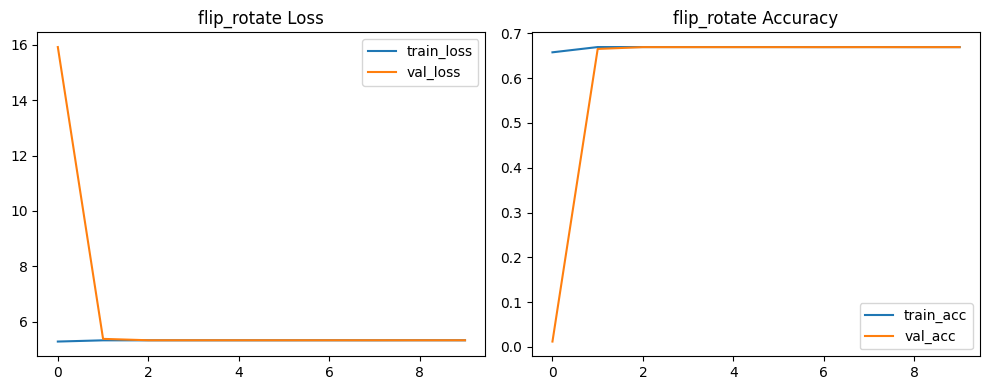


=== Pipeline: flip_rotate_zoom ===


Model: "cnn_scratch"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_2 (Cast)                   │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,832,487 (98.54 MB)

 Trainable params: 25,832,039 (98.54 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.5916 - loss: 5.0437
Epoch 1: val_loss improved from inf to 15.58673, saving model to scratch_aug_flip_rotate_zoom/checkpoints/best.weights.h5
251/251 ━━━━━━━━━━━━━━━━━━━━ 42s 86ms/step - accuracy: 0.5918 - loss: 5.0447 - val_accuracy: 0.0330 - val_loss: 15.5867 - learning_rate: 0.0010
Epoch 2/10
250/251 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.6726 - loss: 5.2775
Epoch 2: val_loss improved from 15.58673 to 5.79532, saving model to scratch_aug_flip_rotate_zoom/checkpoints/best.weights.h5
251/251 ━━━━━━━━━━━━━━━━━━━━ 31s 66ms/step - accuracy: 0.6726 - loss: 5.2779 - val_accuracy: 0.6354 - val_loss: 5.7953 - learning_rate: 0.0010
Epoch 3/10
250/251 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.6769 - loss: 5.2085
Epoch 3: val_loss improved from 5.79532 to 5.32976, saving model to scratch_aug_flip_rotate_zoom/checkpoints/best.weights.h5
251/251 ━━━━━━━━━━━━━━━━━━━━ 31s 67ms/step - accuracy: 0.6768 - loss: 5.2094 - 

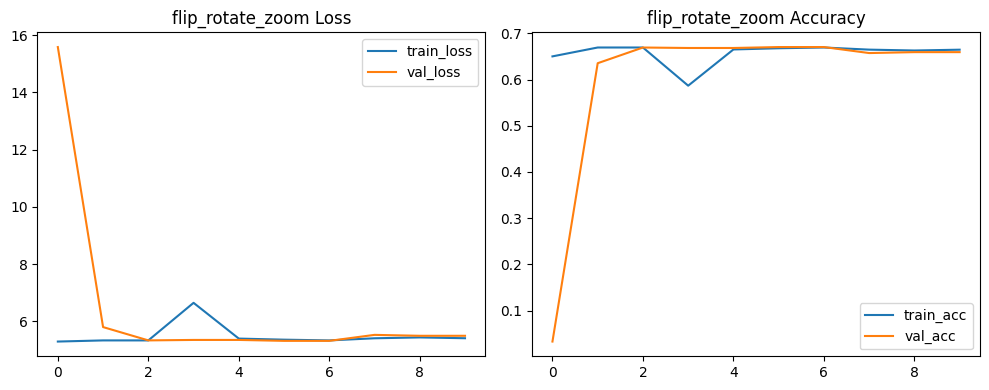


=== Pipeline: flip_rotate_zoom_contrast ===


Model: "cnn_scratch"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_3 (Cast)                   │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,832,487 (98.54 MB)

 Trainable params: 25,832,039 (98.54 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.5581 - loss: 5.3090
Epoch 1: val_loss improved from inf to 15.44518, saving model to scratch_aug_flip_rotate_zoom_contrast/checkpoints/best.weights.h5
251/251 ━━━━━━━━━━━━━━━━━━━━ 46s 98ms/step - accuracy: 0.5584 - loss: 5.3092 - val_accuracy: 0.0400 - val_loss: 15.4452 - learning_rate: 0.0010
Epoch 2/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.6663 - loss: 5.3791
Epoch 2: val_loss improved from 15.44518 to 5.34586, saving model to scratch_aug_flip_rotate_zoom_contrast/checkpoints/best.weights.h5
251/251 ━━━━━━━━━━━━━━━━━━━━ 34s 78ms/step - accuracy: 0.6663 - loss: 5.3789 - val_accuracy: 0.6683 - val_loss: 5.3459 - learning_rate: 0.0010
Epoch 3/10
250/251 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.6761 - loss: 5.2201
Epoch 3: val_loss improved from 5.34586 to 5.32976, saving model to scratch_aug_flip_rotate_zoom_contrast/checkpoints/best.weights.h5
251/251 ━━━━━━━━━━━━━━━━━━━━ 34s 79ms/step - accurac

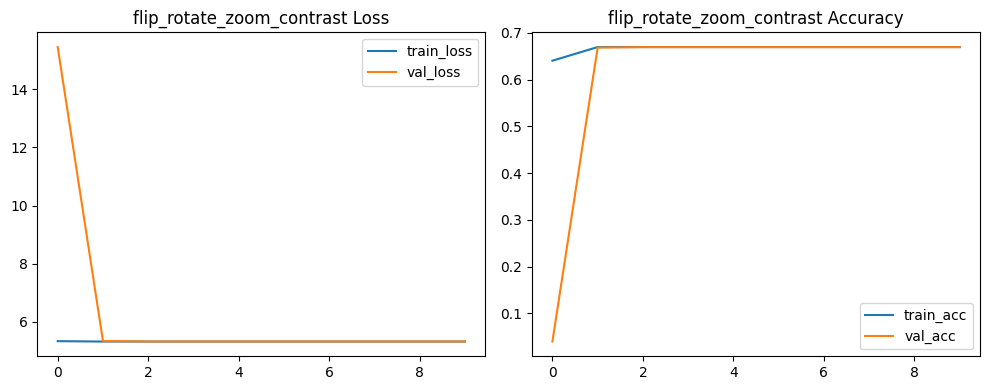

In [ ]:
#2) Gentle augmentation pipelines
pipelines = {
    "flip_rotate": tf.keras.Sequential([
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.05),
    ]),
    "flip_rotate_zoom": tf.keras.Sequential([
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.05),
        tf.keras.layers.RandomZoom(0.05),
    ]),
    "flip_rotate_zoom_contrast": tf.keras.Sequential([
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.05),
        tf.keras.layers.RandomZoom(0.05),
        tf.keras.layers.RandomContrast(0.1),
    ]),
}

n_classes = len(label_encoder.classes_)

# ─── 3) Train & evaluate each variant ──────────────────────────────────
for name, aug in pipelines.items():
    print(f"\n=== Pipeline: {name} ===")
    # Augment train_ds on the fly
    train_aug = train_ds.map(
        lambda img, lbl: (aug(img), lbl),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    # Build fresh instance of your Step 1 model
    model = build_scratch_model(n_classes)
    model.summary()

    # Callbacks: checkpoint & LR reduce
    work_dir = f"scratch_aug_{name}"
    ckpt_dir = os.path.join(work_dir, "checkpoints")
    os.makedirs(ckpt_dir, exist_ok=True)
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(
            filepath=os.path.join(ckpt_dir, "best.weights.h5"),
            monitor="val_loss", save_best_only=True,
            save_weights_only=True, verbose=1
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss", factor=0.5, patience=3, verbose=1
        ),
        tf.keras.callbacks.CSVLogger(
            os.path.join(work_dir, "training_log.csv"), append=False
        ),
    ]

    # Train for 10 epochs
    history = model.fit(
        train_aug,
        validation_data=val_ds,
        epochs=10,
        callbacks=callbacks
    )

    # Restore best weights & test
    model.load_weights(os.path.join(ckpt_dir, "best.weights.h5"))
    loss, acc = model.evaluate(test_ds, verbose=0)
    print(f"{name} → Test Accuracy: {acc:.4f}")

    # Plot curves
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'],   label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title(f"{name} Loss"); plt.legend()

    plt.subplot(1,2,2)
    plt.plot(history.history['accuracy'],   label='train_acc')
    plt.plot(history.history['val_accuracy'], label='val_acc')
    plt.title(f"{name} Accuracy"); plt.legend()

    plt.tight_layout()
    plt.show()


── Training on: original (input shape (224, 224, 3)) ──


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_4 (Cast)                   │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 28, 28, 256)    │         1,02

 Total params: 1,243,687 (4.74 MB)

 Trainable params: 1,241,767 (4.74 MB)

 Non-trainable params: 1,920 (7.50 KB)

Epoch 1/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.3220 - loss: 2.0788
Epoch 1: val_loss improved from inf to 2.44835, saving model to cnn_modality_original/checkpoints/best.weights.h5
251/251 ━━━━━━━━━━━━━━━━━━━━ 47s 119ms/step - accuracy: 0.3222 - loss: 2.0777 - val_accuracy: 0.1339 - val_loss: 2.4483 - learning_rate: 0.0010
Epoch 2/20
250/251 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.3507 - loss: 1.7025
Epoch 2: val_loss improved from 2.44835 to 1.36383, saving model to cnn_modality_original/checkpoints/best.weights.h5
251/251 ━━━━━━━━━━━━━━━━━━━━ 15s 59ms/step - accuracy: 0.3510 - loss: 1.7019 - val_accuracy: 0.6134 - val_loss: 1.3638 - learning_rate: 0.0010
Epoch 3/20
250/251 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.3823 - loss: 1.5629
Epoch 3: val_loss did not improve from 1.36383
251/251 ━━━━━━━━━━━━━━━━━━━━ 15s 58ms/step - accuracy: 0.3826 - loss: 1.5625 - val_accuracy: 0.5275 - val_loss: 1.3999 - learning_rate: 0.0010
Epoch 4/20
250/251 ━━━━━━━━━━━

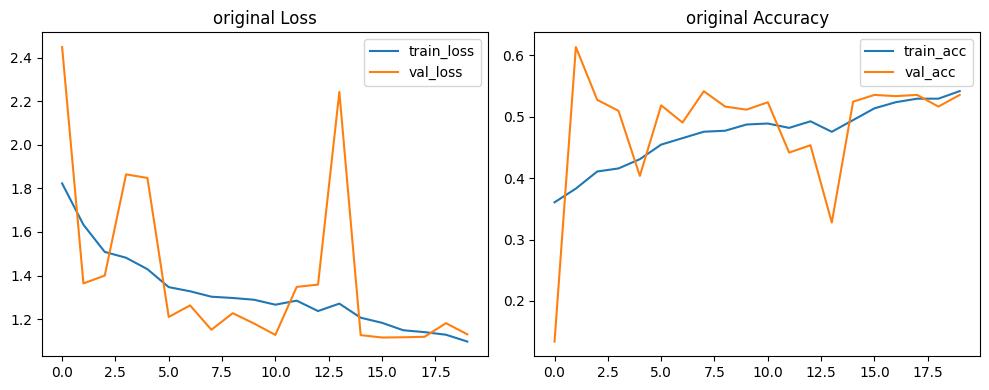


── Training on: mask (input shape (224, 224, 1)) ──


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 224, 224, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_5 (Cast)                   │ (None, 224, 224, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 224, 224, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 28, 28, 256)    │         1,02

 Total params: 1,243,111 (4.74 MB)

 Trainable params: 1,241,191 (4.73 MB)

 Non-trainable params: 1,920 (7.50 KB)

Epoch 1/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1589 - loss: 2.0694
Epoch 1: val_loss improved from inf to 2.19691, saving model to cnn_modality_mask/checkpoints/best.weights.h5
251/251 ━━━━━━━━━━━━━━━━━━━━ 642s 2s/step - accuracy: 0.1588 - loss: 2.0691 - val_accuracy: 0.0140 - val_loss: 2.1969 - learning_rate: 0.0010
Epoch 2/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.1184 - loss: 1.8785
Epoch 2: val_loss improved from 2.19691 to 2.14010, saving model to cnn_modality_mask/checkpoints/best.weights.h5
251/251 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.1184 - loss: 1.8785 - val_accuracy: 0.0210 - val_loss: 2.1401 - learning_rate: 0.0010
Epoch 3/20
249/251 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.1316 - loss: 1.8558
Epoch 3: val_loss did not improve from 2.14010
251/251 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.1316 - loss: 1.8557 - val_accuracy: 0.1169 - val_loss: 2.8337 - learning_rate: 0.0010
Epoch 4/20
250/251 ━━━━━━━━━━━━━━━━━━━━ 0s

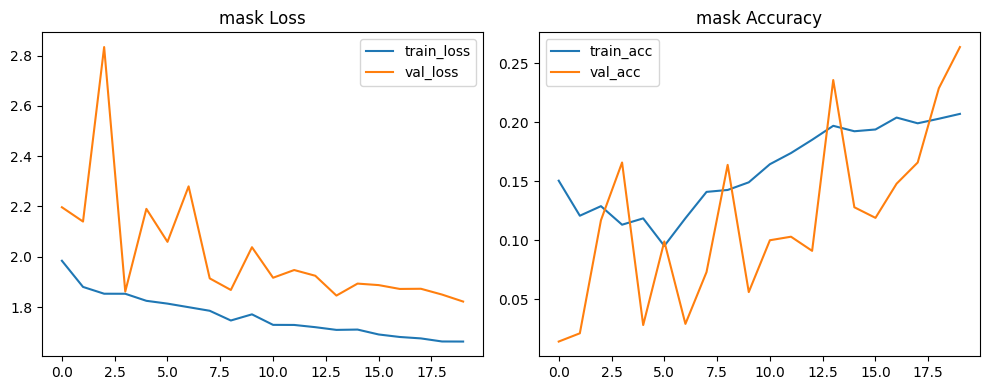


── Training on: combined (input shape (224, 224, 4)) ──


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 224, 224, 4)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_6 (Cast)                   │ (None, 224, 224, 4)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 224, 224, 32)   │         1,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_34          │ (None, 28, 28, 256)    │         1,02

 Total params: 1,243,975 (4.75 MB)

 Trainable params: 1,242,055 (4.74 MB)

 Non-trainable params: 1,920 (7.50 KB)

Epoch 1/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.3109 - loss: 1.9924
Epoch 1: val_loss improved from inf to 3.14369, saving model to cnn_modality_combined/checkpoints/best.weights.h5
251/251 ━━━━━━━━━━━━━━━━━━━━ 52s 142ms/step - accuracy: 0.3111 - loss: 1.9915 - val_accuracy: 0.0180 - val_loss: 3.1437 - learning_rate: 0.0010
Epoch 2/20
250/251 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.3998 - loss: 1.5903
Epoch 2: val_loss improved from 3.14369 to 1.60459, saving model to cnn_modality_combined/checkpoints/best.weights.h5
251/251 ━━━━━━━━━━━━━━━━━━━━ 25s 100ms/step - accuracy: 0.4000 - loss: 1.5899 - val_accuracy: 0.4086 - val_loss: 1.6046 - learning_rate: 0.0010
Epoch 3/20
250/251 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.3652 - loss: 1.6879
Epoch 3: val_loss improved from 1.60459 to 1.32874, saving model to cnn_modality_combined/checkpoints/best.weights.h5
251/251 ━━━━━━━━━━━━━━━━━━━━ 25s 99ms/step - accuracy: 0.3654 - loss: 1.6870 - val_accuracy: 0.5075 

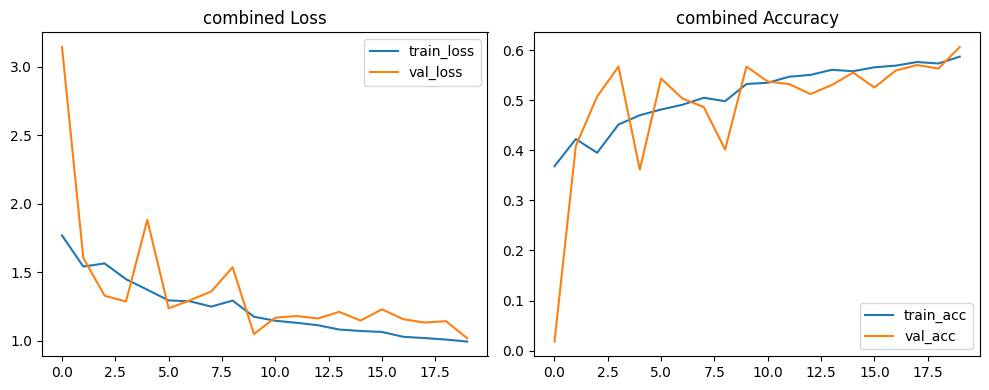

In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils import class_weight

AUTOTUNE = tf.data.AUTOTUNE

# ── 1) Compute class weights for imbalanced HAM10000 ─────────────────────────
y = train_df['dx_int'].values
weights = class_weight.compute_class_weight("balanced", classes=np.unique(y), y=y)
class_weights = dict(enumerate(weights))

# ── 2) Preprocessing fns ────────────────────────────────────────────────────
def preprocess_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, img_size)
    return img / 255.0

def preprocess_mask(path):
    m = tf.io.read_file(path)
    m = tf.image.decode_png(m, channels=1)
    m = tf.image.resize(m, img_size)
    # assume Otsu mask is already 0/255; binarize to 0/1
    return tf.cast(m > 127, tf.float32)

def preprocess_combined(img_path, mask_path):
    img  = preprocess_image(img_path)
    mask = preprocess_mask(mask_path)
    return tf.concat([img, mask], axis=-1)

def make_ds(paths, labels, preprocess_fn):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(lambda p, l: (preprocess_fn(p), l), num_parallel_calls=AUTOTUNE)
    return ds.batch(batch_size).prefetch(AUTOTUNE)

# ── 3) Build train/val/test for each modality ────────────────────────────────
modalities = {
    "original":   ( make_ds(train_df['image_path'], train_df['dx_int'], preprocess_image),
                    make_ds(val_df  ['image_path'], val_df  ['dx_int'], preprocess_image),
                    make_ds(test_df ['image_path'], test_df ['dx_int'], preprocess_image),
                    (224,224,3)
                  ),
    "mask":       ( make_ds(train_df['mask_path'],  train_df['dx_int'], preprocess_mask),
                    make_ds(val_df  ['mask_path'],  val_df  ['dx_int'], preprocess_mask),
                    make_ds(test_df ['mask_path'],  test_df ['dx_int'], preprocess_mask),
                    (224,224,1)
                  ),
    "combined":   ( tf.data.Dataset
                       .from_tensor_slices((train_df['image_path'], train_df['mask_path'], train_df['dx_int']))
                       .map(lambda ip, mp, l: (preprocess_combined(ip, mp), l), num_parallel_calls=AUTOTUNE)
                       .batch(batch_size).prefetch(AUTOTUNE),
                    tf.data.Dataset
                       .from_tensor_slices((val_df  ['image_path'], val_df  ['mask_path'], val_df  ['dx_int']))
                       .map(lambda ip, mp, l: (preprocess_combined(ip, mp), l), num_parallel_calls=AUTOTUNE)
                       .batch(batch_size).prefetch(AUTOTUNE),
                    tf.data.Dataset
                       .from_tensor_slices((test_df ['image_path'], test_df ['mask_path'], test_df ['dx_int']))
                       .map(lambda ip, mp, l: (preprocess_combined(ip, mp), l), num_parallel_calls=AUTOTUNE)
                       .batch(batch_size).prefetch(AUTOTUNE),
                    (224,224,4)
                  )
}

# ── 4) Step-2 CNN builder (takes arbitrary channel count) ───────────────────
def build_model(input_shape, n_classes):
    inp = tf.keras.Input(shape=input_shape)
    x = inp
    for filters in [32, 64, 128]:
        x = tf.keras.layers.Conv2D(filters, 3, padding="same", activation="relu")(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Conv2D(filters, 3, padding="same", activation="relu")(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.MaxPooling2D()(x)
        x = tf.keras.layers.Dropout(0.2)(x)
    # extra 256-filter block
    x = tf.keras.layers.Conv2D(256, 3, padding="same", activation="relu")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(256, 3, padding="same", activation="relu")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(256, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    out = tf.keras.layers.Dense(n_classes, activation="softmax")(x)

    model = tf.keras.Model(inp, out)
    # you can swap in a CosineDecay schedule here if you like,
    # but we'll stick with a fixed LR for clarity:
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

# ── 5) Train & evaluate each modality ──────────────────────────────────────
n_classes = len(label_encoder.classes_)
epochs    = 20

for name, (train_m, val_m, test_m, inp_shape) in modalities.items():
    print(f"\n── Training on: {name} (input shape {inp_shape}) ──")
    model = build_model(inp_shape, n_classes)
    model.summary()

    # callbacks
    work_dir = f"cnn_modality_{name}"
    ckpt_dir = os.path.join(work_dir, "checkpoints")
    os.makedirs(ckpt_dir, exist_ok=True)
    cbs = [
        tf.keras.callbacks.ModelCheckpoint(
            filepath=os.path.join(ckpt_dir, "best.weights.h5"),
            monitor="val_loss", save_best_only=True, save_weights_only=True, verbose=1
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss", factor=0.5, patience=3, verbose=1
        ),
        tf.keras.callbacks.CSVLogger(
            os.path.join(work_dir, "training_log.csv"), append=False
        ),
    ]

    hist = model.fit(
        train_m,
        validation_data=val_m,
        epochs=epochs,
        callbacks=cbs,
        class_weight=class_weights
    )

    # best‐on‐val → test
    model.load_weights(os.path.join(ckpt_dir, "best.weights.h5"))
    loss, acc = model.evaluate(test_m, verbose=0)
    print(f"→ [{name}] Test accuracy: {acc:.4f}")

    # plot
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(hist.history["loss"],   label="train_loss")
    plt.plot(hist.history["val_loss"], label="val_loss")
    plt.title(f"{name} Loss"); plt.legend()

    plt.subplot(1,2,2)
    plt.plot(hist.history["accuracy"],   label="train_acc")
    plt.plot(hist.history["val_accuracy"], label="val_acc")
    plt.title(f"{name} Accuracy"); plt.legend()
    plt.tight_layout(); plt.show()


In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
from tensorflow.keras.callbacks import EarlyStopping

# ── Config ────────────────────────────────────────────────────────────────
AUTOTUNE   = tf.data.AUTOTUNE
batch_size = 32
work_dir   = "cnn_attention"
ckpt_dir   = os.path.join(work_dir, "checkpoints")
os.makedirs(ckpt_dir, exist_ok=True)

# ── 1) Compute class weights ───────────────────────────────────────────────
y = train_df['dx_int'].values
weights = class_weight.compute_class_weight("balanced",
                                            classes=np.unique(y),
                                            y=y)
class_weights = dict(enumerate(weights))

# ── 2) Build attention‐guided CNN ──────────────────────────────────────────
def build_attention_model(n_classes):
    img_in  = tf.keras.Input((224,224,3), name="img_input")
    mask_in = tf.keras.Input((224,224,1), name="mask_input")

    # Block 1 on image
    x = tf.keras.layers.Conv2D(32,3,padding="same",activation="relu")(img_in)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(32,3,padding="same",activation="relu")(x)
    x = tf.keras.layers.MaxPooling2D()(x)      # → (112,112,32)
    x = tf.keras.layers.Dropout(0.2)(x)

    # downsample mask → attention map
    m = tf.keras.layers.MaxPooling2D()(mask_in)            # → (112,112,1)
    m = tf.keras.layers.Conv2D(32,1,padding="same",
           activation="sigmoid", name="mask_attention")(m) # → (112,112,32)

    # apply mask attention
    x = tf.keras.layers.Multiply(name="apply_mask")([x, m])

    # Blocks 2–4
    for filters in [64, 128, 256]:
        x = tf.keras.layers.Conv2D(filters,3,padding="same",activation="relu")(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Conv2D(filters,3,padding="same",activation="relu")(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.MaxPooling2D()(x)
        x = tf.keras.layers.Dropout(0.2)(x)

    # head
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(256, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    out = tf.keras.layers.Dense(n_classes, activation="softmax")(x)

    model = tf.keras.Model([img_in, mask_in], out, name="cnn_attention")
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

# ── 3) Zip your **already-batched** RGB & mask ds ───────────────────────────
def make_attention_ds(rgb_ds, mask_ds):
    return tf.data.Dataset.zip((rgb_ds, mask_ds)) \
               .map(lambda rgb, m: ((rgb[0], m[0]), rgb[1]),
                    num_parallel_calls=AUTOTUNE) \
               .prefetch(AUTOTUNE)

train_attn_ds = make_attention_ds(train_rgb_ds, train_mask_ds)
val_attn_ds   = make_attention_ds(val_rgb_ds,   val_mask_ds)
test_attn_ds  = make_attention_ds(test_rgb_ds,  test_mask_ds)

# ── 4) Callbacks ───────────────────────────────────────────────────────────
callbacks_attn = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(ckpt_dir, "best.weights.h5"),
        monitor="val_loss", save_best_only=True,
        save_weights_only=True, verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5,
        patience=3, verbose=1
    ),
    EarlyStopping(
        monitor="val_loss", patience=5,
        restore_best_weights=True, verbose=1
    ),
    tf.keras.callbacks.CSVLogger(
        os.path.join(work_dir, "training_log.csv"),
        append=False
    ),
]

# ── 5) Build, train & evaluate ─────────────────────────────────────────────
n_classes   = len(label_encoder.classes_)
model_attn  = build_attention_model(n_classes)
model_attn.summary()

history_attn = model_attn.fit(
    train_attn_ds,
    validation_data=val_attn_ds,
    epochs=30,
    callbacks=callbacks_attn,
    class_weight=class_weights
)

model_attn.load_weights(os.path.join(ckpt_dir, "best.weights.h5"))
loss_attn, acc_attn = model_attn.evaluate(test_attn_ds, verbose=0)
print(f"[Attention CNN] Test accuracy: {acc_attn:.4f}")


Model: "cnn_attention"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ img_input           │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_12 (Cast)      │ (None, 224, 224,  │          0 │ img_input[0][0]   │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_54 (Conv2D)  │ (None, 224, 224,  │        896 │ cast_12[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        128 │ conv2d_54[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mask_input          │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_55 (Conv2D)  │ (None, 224, 224,  │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_13 (Cast)      │ (None, 224, 224,  │          0 │ mask_input[0][0]  │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_30    │ (None, 112, 112,  │          0 │ conv2d_55[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_31    │ (None, 112, 112,  │          0 │ cast_13[0][0]     │
│ (MaxPooling2D)      │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_25          │ (None, 112, 112,  │          0 │ max_pooling2d_30… │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mask_attention      │ (None, 112, 112,  │         64 │ max_pooling2d_31… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ apply_mask          │ (None, 112, 112,  │          0 │ dropout_25[0][0], │
│ (Multiply)          │ 32)               │            │ mask_attention[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_56 (Conv2D)  │ (None, 112, 112,  │     18,496 │ apply_mask[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_56[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_57 (Conv2D)  │ (None, 112, 112,  │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_57[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_32    │ (None, 56, 56,    │          0 │ batch_normalizat

 Total params: 1,243,623 (4.74 MB)

 Trainable params: 1,241,767 (4.74 MB)

 Non-trainable params: 1,856 (7.25 KB)

Epoch 1/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.2947 - loss: 2.1101
Epoch 1: val_loss improved from inf to 2.92332, saving model to cnn_attention/checkpoints/best.weights.h5
251/251 ━━━━━━━━━━━━━━━━━━━━ 51s 138ms/step - accuracy: 0.2949 - loss: 2.1093 - val_accuracy: 0.0200 - val_loss: 2.9233 - learning_rate: 0.0010
Epoch 2/30
250/251 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.3410 - loss: 1.7568
Epoch 2: val_loss improved from 2.92332 to 1.86307, saving model to cnn_attention/checkpoints/best.weights.h5
251/251 ━━━━━━━━━━━━━━━━━━━━ 25s 99ms/step - accuracy: 0.3414 - loss: 1.7563 - val_accuracy: 0.2927 - val_loss: 1.8631 - learning_rate: 0.0010
Epoch 3/30
250/251 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.3379 - loss: 1.7933
Epoch 3: val_loss did not improve from 1.86307
251/251 ━━━━━━━━━━━━━━━━━━━━ 25s 97ms/step - accuracy: 0.3383 - loss: 1.7919 - val_accuracy: 0.1578 - val_loss: 2.1573 - learning_rate: 0.0010
Epoch 4/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 86


=== TRANSFER-LEARNING on rgb (input_shape=(224, 224, 3)) ===


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 7)              │        14,343 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,602,055 (90.03 MB)

 Trainable params: 14,343 (56.03 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.1366 - loss: 2.2019
Epoch 1: val_loss improved from inf to 1.91142, saving model to transfer_resnet50/checkpoints/rgb.weights.h5
251/251 ━━━━━━━━━━━━━━━━━━━━ 43s 112ms/step - accuracy: 0.1367 - loss: 2.2017 - val_accuracy: 0.0519 - val_loss: 1.9114 - learning_rate: 1.0000e-04
Epoch 2/15
249/251 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.1781 - loss: 2.0568
Epoch 2: val_loss did not improve from 1.91142
251/251 ━━━━━━━━━━━━━━━━━━━━ 16s 57ms/step - accuracy: 0.1780 - loss: 2.0570 - val_accuracy: 0.0509 - val_loss: 1.9189 - learning_rate: 1.0000e-04
Epoch 3/15
250/251 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.1578 - loss: 2.0815
Epoch 3: val_loss improved from 1.91142 to 1.89332, saving model to transfer_resnet50/checkpoints/rgb.weights.h5
251/251 ━━━━━━━━━━━━━━━━━━━━ 17s 60ms/step - accuracy: 0.1577 - loss: 2.0815 - val_accuracy: 0.0509 - val_loss: 1.8933 - learning_rate: 1.0000e-04
Epoch 4/15
249/251 ━━━━━━━━━

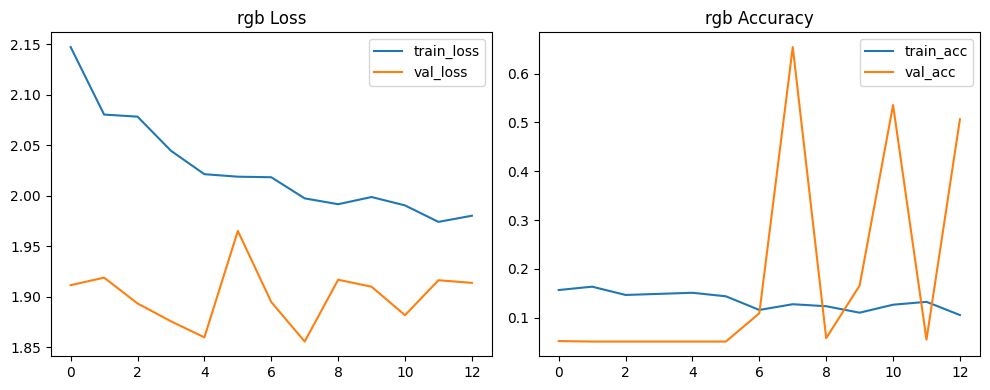


=== TRANSFER-LEARNING on mask (input_shape=(224, 224, 3)) ===


Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_7      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 7)              │        14,343 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,602,055 (90.03 MB)

 Trainable params: 14,343 (56.03 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.2277 - loss: 2.1457
Epoch 1: val_loss improved from inf to 1.84244, saving model to transfer_resnet50/checkpoints/mask.weights.h5
251/251 ━━━━━━━━━━━━━━━━━━━━ 32s 81ms/step - accuracy: 0.2275 - loss: 2.1455 - val_accuracy: 0.3636 - val_loss: 1.8424 - learning_rate: 1.0000e-04
Epoch 2/15
250/251 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.1496 - loss: 1.9833
Epoch 2: val_loss did not improve from 1.84244
251/251 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/step - accuracy: 0.1495 - loss: 1.9836 - val_accuracy: 0.2737 - val_loss: 1.8642 - learning_rate: 1.0000e-04
Epoch 3/15
249/251 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.1484 - loss: 1.9938
Epoch 3: val_loss improved from 1.84244 to 1.82256, saving model to transfer_resnet50/checkpoints/mask.weights.h5
251/251 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.1482 - loss: 1.9939 - val_accuracy: 0.3836 - val_loss: 1.8226 - learning_rate: 1.0000e-04
Epoch 4/15
248/251 ━━━━━━━━

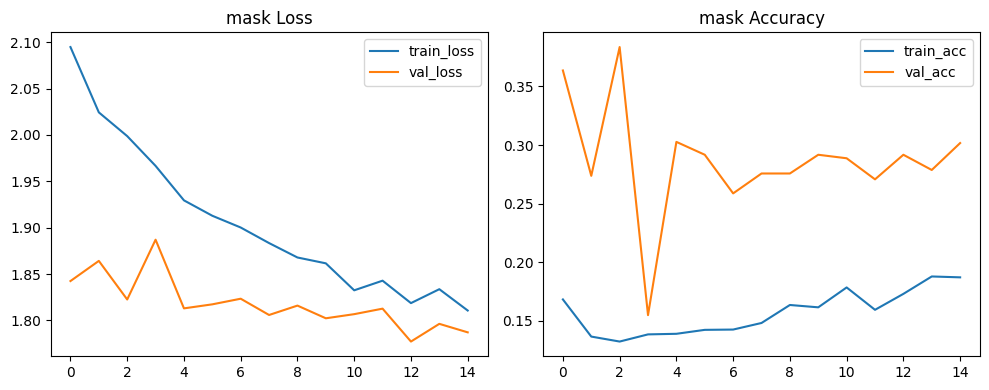


=== TRANSFER-LEARNING on masked (input_shape=(224, 224, 3)) ===


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_8      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 7)              │        14,343 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,602,055 (90.03 MB)

 Trainable params: 14,343 (56.03 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.0957 - loss: 2.1389
Epoch 1: val_loss improved from inf to 1.90855, saving model to transfer_resnet50/checkpoints/masked.weights.h5
251/251 ━━━━━━━━━━━━━━━━━━━━ 47s 128ms/step - accuracy: 0.0958 - loss: 2.1388 - val_accuracy: 0.1508 - val_loss: 1.9085 - learning_rate: 1.0000e-04
Epoch 2/15
249/251 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.1271 - loss: 2.0581
Epoch 2: val_loss improved from 1.90855 to 1.89582, saving model to transfer_resnet50/checkpoints/masked.weights.h5
251/251 ━━━━━━━━━━━━━━━━━━━━ 27s 96ms/step - accuracy: 0.1270 - loss: 2.0581 - val_accuracy: 0.2198 - val_loss: 1.8958 - learning_rate: 1.0000e-04
Epoch 3/15
249/251 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.1307 - loss: 2.0402
Epoch 3: val_loss improved from 1.89582 to 1.84382, saving model to transfer_resnet50/checkpoints/masked.weights.h5
251/251 ━━━━━━━━━━━━━━━━━━━━ 27s 96ms/step - accuracy: 0.1306 - loss: 2.0403 - val_accuracy: 0.4585 

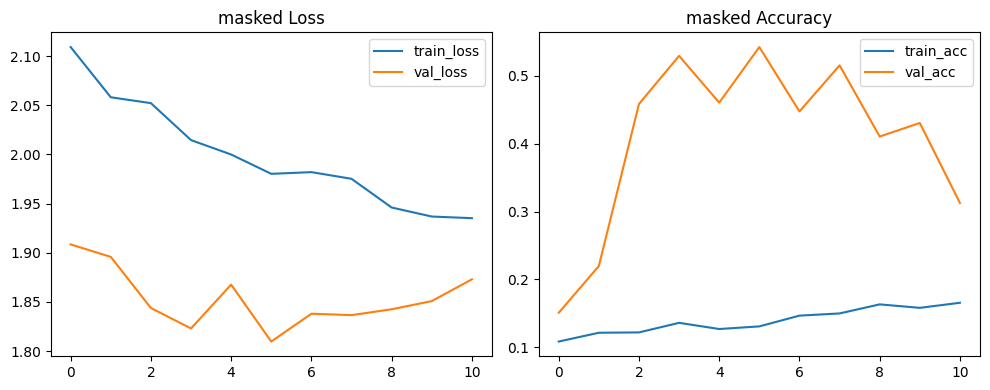

In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
from tensorflow.keras.callbacks import (
    ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, CSVLogger
)
from tensorflow.keras.applications import ResNet50

# ── CONFIG ─────────────────────────────────────────────────────────────────
IMG_SIZE   = (224, 224)
BATCH_SIZE = 32
AUTOTUNE   = tf.data.AUTOTUNE
WORK_DIR   = "transfer_resnet50"
CKPT_DIR   = os.path.join(WORK_DIR, "checkpoints")
os.makedirs(CKPT_DIR, exist_ok=True)

# ── 1) COMPUTE CLASS WEIGHTS ─────────────────────────────────────────────────
y = train_df['dx_int'].values
weights = class_weight.compute_class_weight(
    "balanced",
    classes=np.unique(y),
    y=y
)
CLASS_WEIGHTS = dict(enumerate(weights))
n_classes     = len(label_encoder.classes_)

# ── 2) DATA PREP HELPERS ──────────────────────────────────────────────────────
def load_and_resize(path, channels):
    img = tf.io.read_file(path)
    if channels == 3:
        img = tf.image.decode_jpeg(img, channels=3)
    else:
        img = tf.image.decode_png(img, channels=1)
    img = tf.image.resize(img, IMG_SIZE)
    return img / 255.0

def prep_rgb(path, label):
    return load_and_resize(path, 3), label

def prep_mask(path, label):
    m = load_and_resize(path, 1)
    m = tf.cast(m > 0.5, tf.float32)
    # tile to 3 channels so that ResNet input_shape=(224,224,3)
    return tf.tile(m, [1,1,3]), label

def prep_masked(path, mask_path, label):
    rgb  = load_and_resize(path, 3)
    mask = load_and_resize(mask_path, 1)
    mask = tf.cast(mask > 0.5, tf.float32)
    return rgb * mask, label

def make_ds_single(paths, labels, prep_fn):
    return (
        tf.data.Dataset
          .from_tensor_slices((paths, labels))
          .map(prep_fn, num_parallel_calls=AUTOTUNE)
          .shuffle(1000)
          .batch(BATCH_SIZE)
          .prefetch(AUTOTUNE)
    )

def make_ds_masked(img_paths, mask_paths, labels):
    return (
        tf.data.Dataset
          .from_tensor_slices((img_paths, mask_paths, labels))
          .map(prep_masked, num_parallel_calls=AUTOTUNE)
          .shuffle(1000)
          .batch(BATCH_SIZE)
          .prefetch(AUTOTUNE)
    )

# ── 3) BUILD TF.DATASETS FOR EACH MODALITY ───────────────────────────────────
modalities = {
    "rgb": (
        make_ds_single(train_df['image_path'], train_df['dx_int'], prep_rgb),
        make_ds_single(val_df  ['image_path'], val_df  ['dx_int'], prep_rgb),
        make_ds_single(test_df ['image_path'], test_df ['dx_int'], prep_rgb),
        (224,224,3)
    ),
    "mask": (
        make_ds_single(train_df['mask_path'],  train_df['dx_int'], prep_mask),
        make_ds_single(val_df  ['mask_path'],  val_df  ['dx_int'], prep_mask),
        make_ds_single(test_df ['mask_path'],  test_df ['dx_int'], prep_mask),
        (224,224,3)
    ),
    "masked": (
        make_ds_masked(train_df['image_path'],
                       train_df['mask_path'],
                       train_df['dx_int']),
        make_ds_masked(val_df  ['image_path'],
                       val_df  ['mask_path'],
                       val_df  ['dx_int']),
        make_ds_masked(test_df ['image_path'],
                       test_df ['mask_path'],
                       test_df ['dx_int']),
        (224,224,3)
    )
}

# ── 4) TRANSFER-LEARNING MODEL BUILDER ────────────────────────────────────────
def build_tl_model(input_shape, n_classes):
    base = ResNet50(
        weights="imagenet",
        include_top=False,
        input_shape=input_shape
    )
    base.trainable = False

    inp = tf.keras.Input(shape=input_shape)
    x   = base(inp, training=False)
    x   = tf.keras.layers.GlobalAveragePooling2D()(x)
    x   = tf.keras.layers.Dropout(0.3)(x)
    out = tf.keras.layers.Dense(n_classes, activation="softmax")(x)

    model = tf.keras.Model(inp, out)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

# ── 5) TRAIN & EVALUATE ──────────────────────────────────────────────────────
EPOCHS = 15

for name, (train_ds_mod, val_ds_mod, test_ds_mod, input_shape) in modalities.items():
    print(f"\n=== TRANSFER-LEARNING on {name} (input_shape={input_shape}) ===")
    model = build_tl_model(input_shape, n_classes)
    model.summary()

    callbacks = [
        ModelCheckpoint(
            filepath=os.path.join(CKPT_DIR, f"{name}.weights.h5"),
            monitor="val_loss",
            save_best_only=True,
            save_weights_only=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor="val_loss",
            factor=0.5,
            patience=3,
            verbose=1
        ),
        EarlyStopping(
            monitor="val_loss",
            patience=5,
            restore_best_weights=True,
            verbose=1
        ),
        CSVLogger(
            os.path.join(WORK_DIR, f"{name}_transfer.log.csv"),
            append=False
        ),
    ]

    hist = model.fit(
        train_ds_mod,
        validation_data=val_ds_mod,
        epochs=EPOCHS,
        callbacks=callbacks,
        class_weight=CLASS_WEIGHTS
    )

    # load best weights & test
    model.load_weights(os.path.join(CKPT_DIR, f"{name}.weights.h5"))
    loss, acc = model.evaluate(test_ds_mod, verbose=0)
    print(f"→ [{name}] Test Accuracy: {acc:.4f}")

    # plot
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(hist.history["loss"],   label="train_loss")
    plt.plot(hist.history["val_loss"], label="val_loss")
    plt.title(f"{name} Loss"); plt.legend()
    plt.subplot(1,2,2)
    plt.plot(hist.history["accuracy"],   label="train_acc")
    plt.plot(hist.history["val_accuracy"], label="val_acc")
    plt.title(f"{name} Accuracy"); plt.legend()
    plt.tight_layout()
    plt.show()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "efficientnet_multi"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ in_rgb (InputLayer) │ (None, 224, 224,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ in_mask_rgb         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ in_masked           │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ efficientnetb0      │ (None, 7, 7,      │  4,049,571 │ in_rgb[0][0],     │
│ (Functional)        │ 1280)             │            │ in_mask_rgb[0][0… │
│                     │                   │            │ in_masked[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ efficientnetb0[0… │
│ (GlobalAveragePool… │                   │            │ efficientnetb0[1… │
│                     │                   │            │ efficientnetb0[2… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 3840)      │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ global_average_p… │
│                     │                   │            │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_25 (Dense)    │ (None, 512)       │  1,966,592 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_36          │ (None, 512)       │          0 │ dense_25[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_26 (Dense)    │ (None, 7)         │      3,591 │ dropout_36[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,019,754 (22.96 MB)

 Trainable params: 1,970,183 (7.52 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

Epoch 1/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - accuracy: 0.1211 - loss: 2.0288
Epoch 1: val_loss improved from inf to 1.91129, saving model to multi_input_efficientnet/checkpoints/multi.weights.h5
251/251 ━━━━━━━━━━━━━━━━━━━━ 162s 381ms/step - accuracy: 0.1211 - loss: 2.0287 - val_accuracy: 0.0140 - val_loss: 1.9113 - learning_rate: 1.0000e-04
Epoch 2/20
250/251 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.1118 - loss: 1.9676
Epoch 2: val_loss improved from 1.91129 to 1.88716, saving model to multi_input_efficientnet/checkpoints/multi.weights.h5
251/251 ━━━━━━━━━━━━━━━━━━━━ 52s 185ms/step - accuracy: 0.1122 - loss: 1.9676 - val_accuracy: 0.6693 - val_loss: 1.8872 - learning_rate: 1.0000e-04
Epoch 3/20
250/251 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.2305 - loss: 1.9571
Epoch 3: val_loss did not improve from 1.88716
251/251 ━━━━━━━━━━━━━━━━━━━━ 51s 181ms/step - accuracy: 0.2298 - loss: 1.9570 - val_accuracy: 0.6693 - val_loss: 1.9022 - learning_rate: 1.0000e-04
Epoc

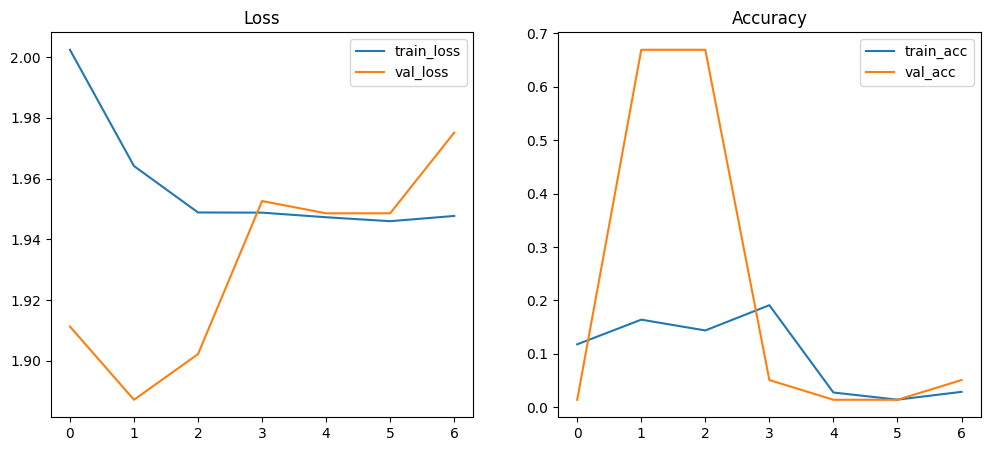

In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, CSVLogger

# ── CONFIGURATION ─────────────────────────────────────────────────────────────
IMG_SIZE    = (224, 224)
BATCH_SIZE  = 32
AUTOTUNE    = tf.data.AUTOTUNE
WORK_DIR    = "multi_input_efficientnet"
CKPT_DIR    = os.path.join(WORK_DIR, "checkpoints")
os.makedirs(CKPT_DIR, exist_ok=True)

# ── 1) COMPUTE CLASS WEIGHTS ──────────────────────────────────────────────────
y_train = train_df['dx_int'].values
CLASS_WEIGHTS = dict(enumerate(class_weight.compute_class_weight(
    "balanced", classes=np.unique(y_train), y=y_train
)))

# ── 2) PREPROCESSING FUNCTIONS ────────────────────────────────────────────────
def load_and_resize(path, channels):
    img = tf.io.read_file(path)
    if channels == 3:
        img = tf.image.decode_jpeg(img, channels=3)
    else:
        img = tf.image.decode_png(img, channels=1)
    img = tf.image.resize(img, IMG_SIZE)
    return img / 255.0

def prep_rgb(path, label):
    """Load and normalize RGB image."""
    return load_and_resize(path, 3), label

def prep_mask_rgb(path, label):
    """Load mask, binarize, and tile to 3 channels for backbone."""
    mask = load_and_resize(path, 1)
    mask = tf.cast(mask > 0.5, tf.float32)
    mask3 = tf.tile(mask, [1, 1, 3])
    return mask3, label

def prep_masked(img_path, mask_path, label):
    """Load RGB and mask, binarize mask, and apply it to RGB."""
    rgb = load_and_resize(img_path, 3)
    mask = load_and_resize(mask_path, 1)
    mask = tf.cast(mask > 0.5, tf.float32)
    return rgb * mask, label

# ── 3) BUILD DATASETS FOR EACH MODALITY ────────────────────────────────────────
# Original RGB
train_rgb_ds = tf.data.Dataset.from_tensor_slices((train_df['image_path'], train_df['dx_int']))
train_rgb_ds = train_rgb_ds.map(prep_rgb, num_parallel_calls=AUTOTUNE) \
                           .shuffle(1000) \
                           .batch(BATCH_SIZE) \
                           .prefetch(AUTOTUNE)

val_rgb_ds   = tf.data.Dataset.from_tensor_slices((val_df  ['image_path'], val_df  ['dx_int']))
val_rgb_ds   = val_rgb_ds.map(prep_rgb, num_parallel_calls=AUTOTUNE) \
                         .batch(BATCH_SIZE) \
                         .prefetch(AUTOTUNE)

test_rgb_ds  = tf.data.Dataset.from_tensor_slices((test_df ['image_path'], test_df ['dx_int']))
test_rgb_ds  = test_rgb_ds.map(prep_rgb, num_parallel_calls=AUTOTUNE) \
                           .batch(BATCH_SIZE) \
                           .prefetch(AUTOTUNE)

# Tiled mask as 3-channel
train_mask_rgb_ds = tf.data.Dataset.from_tensor_slices((train_df['mask_path'], train_df['dx_int']))
train_mask_rgb_ds = train_mask_rgb_ds.map(prep_mask_rgb, num_parallel_calls=AUTOTUNE) \
                                     .shuffle(1000) \
                                     .batch(BATCH_SIZE) \
                                     .prefetch(AUTOTUNE)

val_mask_rgb_ds   = tf.data.Dataset.from_tensor_slices((val_df  ['mask_path'], val_df  ['dx_int']))
val_mask_rgb_ds   = val_mask_rgb_ds.map(prep_mask_rgb, num_parallel_calls=AUTOTUNE) \
                                   .batch(BATCH_SIZE) \
                                   .prefetch(AUTOTUNE)

test_mask_rgb_ds  = tf.data.Dataset.from_tensor_slices((test_df ['mask_path'], test_df ['dx_int']))
test_mask_rgb_ds  = test_mask_rgb_ds.map(prep_mask_rgb, num_parallel_calls=AUTOTUNE) \
                                     .batch(BATCH_SIZE) \
                                     .prefetch(AUTOTUNE)

# Masked RGB (original multiplied by mask)
train_masked_ds = tf.data.Dataset.from_tensor_slices(
    (train_df['image_path'], train_df['mask_path'], train_df['dx_int'])
)
train_masked_ds = train_masked_ds.map(prep_masked, num_parallel_calls=AUTOTUNE) \
                                 .shuffle(1000) \
                                 .batch(BATCH_SIZE) \
                                 .prefetch(AUTOTUNE)

val_masked_ds   = tf.data.Dataset.from_tensor_slices(
    (val_df  ['image_path'], val_df  ['mask_path'], val_df  ['dx_int'])
)
val_masked_ds   = val_masked_ds.map(prep_masked, num_parallel_calls=AUTOTUNE) \
                               .batch(BATCH_SIZE) \
                               .prefetch(AUTOTUNE)

test_masked_ds  = tf.data.Dataset.from_tensor_slices(
    (test_df ['image_path'], test_df ['mask_path'], test_df ['dx_int'])
)
test_masked_ds  = test_masked_ds.map(prep_masked, num_parallel_calls=AUTOTUNE) \
                                 .batch(BATCH_SIZE) \
                                 .prefetch(AUTOTUNE)

# ── 4) ZIP THREE STREAMS INTO MULTI-INPUT DATASET ────────────────────────────
def zip_three(ds1, ds2, ds3):
    return tf.data.Dataset.zip((ds1, ds2, ds3)) \
           .map(lambda a, b, c: ((a[0], b[0], c[0]), a[1]),
                num_parallel_calls=AUTOTUNE) \
           .prefetch(AUTOTUNE)

train_multi_ds = zip_three(train_rgb_ds, train_mask_rgb_ds, train_masked_ds)
val_multi_ds   = zip_three(val_rgb_ds,   val_mask_rgb_ds,   val_masked_ds)
test_multi_ds  = zip_three(test_rgb_ds,  test_mask_rgb_ds,  test_masked_ds)

# ── 5) BUILD MULTI-INPUT EFFICIENTNET MODEL ─────────────────────────────────
def build_multi_input_model(n_classes):
    # Define three inputs
    in_rgb      = tf.keras.Input((*IMG_SIZE, 3), name="in_rgb")
    in_mask_rgb = tf.keras.Input((*IMG_SIZE, 3), name="in_mask_rgb")
    in_masked   = tf.keras.Input((*IMG_SIZE, 3), name="in_masked")

    # Shared EfficientNetB0 backbone (frozen)
    backbone = EfficientNetB0(include_top=False, weights="imagenet", input_shape=(*IMG_SIZE, 3))
    backbone.trainable = False

    # Extract features from each input
    feat1 = backbone(in_rgb)
    feat2 = backbone(in_mask_rgb)
    feat3 = backbone(in_masked)

    # Global average pooling
    gap = tf.keras.layers.GlobalAveragePooling2D()
    f1, f2, f3 = gap(feat1), gap(feat2), gap(feat3)

    # Concatenate the pooled features
    x = tf.keras.layers.Concatenate()([f1, f2, f3])

    # Classification head
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(n_classes, activation="softmax")(x)

    model = tf.keras.Model(inputs=[in_rgb, in_mask_rgb, in_masked], outputs=outputs,
                           name="efficientnet_multi")
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model

# ── 6) TRAIN & EVALUATE ───────────────────────────────────────────────────────
n_classes = len(label_encoder.classes_)
model = build_multi_input_model(n_classes)
model.summary()

callbacks = [
    ModelCheckpoint(os.path.join(CKPT_DIR, "multi.weights.h5"),
                    monitor="val_loss", save_best_only=True, save_weights_only=True, verbose=1),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1),
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1),
    CSVLogger(os.path.join(WORK_DIR, "multi.log.csv"))
]

history = model.fit(
    train_multi_ds,
    validation_data=val_multi_ds,
    epochs=20,
    callbacks=callbacks,
    class_weight=CLASS_WEIGHTS
)

# Load best weights and evaluate on test set
model.load_weights(os.path.join(CKPT_DIR, "multi.weights.h5"))
loss, acc = model.evaluate(test_multi_ds, verbose=0)
print(f"[Multi-Input EfficientNet] Test accuracy: {acc:.4f}")

# Plot training curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.title("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.title("Accuracy")
plt.legend()
plt.show()


In [ ]:
# import os
# import numpy as np
# import tensorflow as tf
# from tensorflow.keras import layers, models
# from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, CSVLogger
# from tensorflow.keras.applications import EfficientNetB0
# from sklearn.utils import class_weight

# # ── 1) GLOBAL CONFIG ─────────────────────────────────────────────────────────
# IMG_SIZE   = (224,224)
# BATCH_SIZE = 32
# WORK_DIR   = "transfer_3phases"
# CKPT_DIR   = os.path.join(WORK_DIR,"checkpoints")
# os.makedirs(CKPT_DIR, exist_ok=True)

# # compute class weights to handle imbalance
# y = train_df.dx_int.values
# w = class_weight.compute_class_weight("balanced", classes=np.unique(y), y=y)
# CLASS_WEIGHTS = dict(enumerate(w))

# AUTOTUNE = tf.data.AUTOTUNE

# # ── 2) PREPROCESSING FUNCTIONS ────────────────────────────────────────────────
# def load_and_resize(path, channels):
#     """Load JPEG/PNG, decode to `channels`, resize to IMG_SIZE, scale to [0,1]."""
#     img = tf.io.read_file(path)
#     img = tf.image.decode_image(img, channels=channels, expand_animations=False)
#     img = tf.image.resize(img, IMG_SIZE)
#     return img / 255.0

# def prep_rgb(path, label):
#     """Raw RGB input (224×224×3)."""
#     return load_and_resize(path, 3), label

# def prep_mask_as_rgb(path, label):
#     """Otsu mask → binarize → tile to 3 channels (224×224×3)."""
#     m = load_and_resize(path, 1)
#     m = tf.cast(m > 0.5, tf.float32)
#     m3 = tf.tile(m, [1,1,3])
#     return m3, label

# def prep_masked(path, mask_path, label):
#     """
#     Element‑wise multiply RGB by mask:
#       - rgb:   (224,224,3)
#       - mask:  (224,224,1) → tile → (224,224,3)
#       → masked_rgb: (224,224,3)
#     """
#     rgb = load_and_resize(path, 3)
#     m   = load_and_resize(mask_path, 1)
#     m   = tf.cast(m > 0.5, tf.float32)
#     m3  = tf.tile(m, [1,1,3])
#     return rgb * m3, label

# # ── 3) DATASET BUILDERS ───────────────────────────────────────────────────────
# def make_ds(paths, labels, prep_fn, extra_paths=None):
#     """
#     Build a tf.data.Dataset:
#       - if extra_paths is None: map (path, label) → prep_fn
#       - otherwise map (path, extra_path, label) → prep_fn
#       - shuffle, batch, prefetch
#     """
#     if extra_paths is None:
#         ds = tf.data.Dataset.from_tensor_slices((paths, labels))
#         ds = ds.map(prep_fn, num_parallel_calls=AUTOTUNE)
#     else:
#         ds = tf.data.Dataset.from_tensor_slices((paths, extra_paths, labels))
#         ds = ds.map(prep_fn, num_parallel_calls=AUTOTUNE)
#     return ds.shuffle(1000).batch(BATCH_SIZE).prefetch(AUTOTUNE)

# # build train/val/test for each modality
# train_rgb      = make_ds(train_df.image_path, train_df.dx_int,      prep_rgb)
# val_rgb        = make_ds(val_df.image_path,   val_df.dx_int,        prep_rgb)
# train_maskrgb  = make_ds(train_df.mask_path,  train_df.dx_int,      prep_mask_as_rgb)
# val_maskrgb    = make_ds(val_df.mask_path,    val_df.dx_int,        prep_mask_as_rgb)
# train_masked   = make_ds(train_df.image_path, train_df.dx_int,      prep_masked, extra_paths=train_df.mask_path)
# val_masked     = make_ds(val_df.image_path,   val_df.dx_int,        prep_masked, extra_paths=val_df.mask_path)
# test_rgb       = make_ds(test_df.image_path,  test_df.dx_int,       prep_rgb)
# test_maskrgb   = make_ds(test_df.mask_path,   test_df.dx_int,       prep_mask_as_rgb)
# test_masked    = make_ds(test_df.image_path,  test_df.dx_int,       prep_masked, extra_paths=test_df.mask_path)

# # zip into a 3‑input dataset ((rgb, mask_rgb, masked), label)
# train_multi = tf.data.Dataset.zip((train_rgb, train_maskrgb, train_masked)) \
#     .map(lambda a,b,c: ((a[0], b[0], c[0]), a[1]), num_parallel_calls=AUTOTUNE) \
#     .prefetch(AUTOTUNE)

# val_multi = tf.data.Dataset.zip((val_rgb, val_maskrgb, val_masked)) \
#     .map(lambda a,b,c: ((a[0], b[0], c[0]), a[1]), num_parallel_calls=AUTOTUNE) \
#     .prefetch(AUTOTUNE)

# test_multi = tf.data.Dataset.zip((test_rgb, test_maskrgb, test_masked)) \
#     .map(lambda a,b,c: ((a[0], b[0], c[0]), a[1]), num_parallel_calls=AUTOTUNE) \
#     .prefetch(AUTOTUNE)

# # ── 4) MODEL FACTORY ─────────────────────────────────────────────────────────
# def build_multi_effnet():
#     """
#     Multi‑input EfficientNetB0:
#       - three 3‑channel inputs → one shared backbone
#       - global‑pool & concatenate → head → 7‑way softmax
#     """
#     in1 = layers.Input((*IMG_SIZE,3), name="rgb")
#     in2 = layers.Input((*IMG_SIZE,3), name="maskrgb")
#     in3 = layers.Input((*IMG_SIZE,3), name="masked")

#     backbone = EfficientNetB0(include_top=False, weights="imagenet", pooling=None)
#     backbone.trainable = False

#     f1 = backbone(in1)
#     f2 = backbone(in2)
#     f3 = backbone(in3)

#     p1 = layers.GlobalAveragePooling2D()(f1)
#     p2 = layers.GlobalAveragePooling2D()(f2)
#     p3 = layers.GlobalAveragePooling2D()(f3)

#     x = layers.Concatenate()([p1,p2,p3])
#     x = layers.Dense(512, activation="relu")(x)
#     x = layers.Dropout(0.3)(x)
#     out = layers.Dense(len(np.unique(y)), activation="softmax")(x)

#     model = models.Model([in1,in2,in3], out, name="multi_effnetb0")
#     return model

# # ── 5) PHASE‑WISE FINE‑TUNING ─────────────────────────────────────────────────
# model = build_multi_effnet()
# model.summary()

# # utility to create callbacks for each phase
# def make_cbs(phase):
#     return [
#         ModelCheckpoint(os.path.join(CKPT_DIR,f"phase{phase}.weights.h5"),
#                        monitor="val_loss", save_best_only=True, save_weights_only=True, verbose=1),
#         ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1),
#         EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1),
#         CSVLogger(os.path.join(WORK_DIR,f"phase{phase}.log.csv"))
#     ]

# # — Phase 1: train only new head
# for layer in model.layers:
#     layer.trainable = layer.name not in backbone.layers  # freeze backbone
# model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
#               loss="sparse_categorical_crossentropy", metrics=["accuracy"])
# h1 = model.fit(train_multi, validation_data=val_multi,
#                epochs=8, callbacks=make_cbs(1),
#                class_weight=CLASS_WEIGHTS, verbose=2)

# # — Phase 2: unfreeze last 20 layers of backbone
# for layer in backbone.layers[-20:]:
#     layer.trainable = True
# model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
#               loss="sparse_categorical_crossentropy", metrics=["accuracy"])
# h2 = model.fit(train_multi, validation_data=val_multi,
#                epochs=8, callbacks=make_cbs(2),
#                class_weight=CLASS_WEIGHTS, verbose=2)

# # — Phase 3: unfreeze entire backbone
# for layer in backbone.layers:
#     layer.trainable = True
# model.compile(optimizer=tf.keras.optimizers.Adam(1e-6),
#               loss="sparse_categorical_crossentropy", metrics=["accuracy"])
# h3 = model.fit(train_multi, validation_data=val_multi,
#                epochs=8, callbacks=make_cbs(3),
#                class_weight=CLASS_WEIGHTS, verbose=2)

# # ── 6) FINAL EVALUATION ───────────────────────────────────────────────────────
# loss, acc = model.evaluate(test_multi, verbose=0)
# print(f"Final test accuracy: {acc:.2%}")


Model: "multi_effnetb0"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ rgb (InputLayer)    │ (None, 224, 224,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ maskrgb             │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masked (InputLayer) │ (None, 224, 224,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ efficientnetb0      │ (None, 7, 7,      │  4,049,571 │ rgb[0][0],        │
│ (Functional)        │ 1280)             │            │ maskrgb[0][0],    │
│                     │                   │            │ masked[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ efficientnetb0[0… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ efficientnetb0[1… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ efficientnetb0[2… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 3840)      │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ global_average_p… │
│                     │                   │            │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 512)       │  1,966,592 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 512)       │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 7)         │      3,591 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,019,754 (22.96 MB)

 Trainable params: 1,970,183 (7.52 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

Epoch 1/8

Epoch 1: val_loss improved from inf to 1.75807, saving model to transfer_3phases/checkpoints/phase1.weights.h5
251/251 - 331s - 1s/step - accuracy: 0.3993 - loss: 1.6799 - val_accuracy: 0.3257 - val_loss: 1.7581 - learning_rate: 1.0000e-04
Epoch 2/8

Epoch 2: val_loss improved from 1.75807 to 1.46853, saving model to transfer_3phases/checkpoints/phase1.weights.h5
251/251 - 57s - 227ms/step - accuracy: 0.5824 - loss: 1.0700 - val_accuracy: 0.5774 - val_loss: 1.4685 - learning_rate: 1.0000e-04
Epoch 3/8

Epoch 3: val_loss did not improve from 1.46853
251/251 - 55s - 221ms/step - accuracy: 0.6453 - loss: 0.7776 - val_accuracy: 0.4476 - val_loss: 1.5228 - learning_rate: 1.0000e-04
Epoch 4/8

Epoch 4: val_loss improved from 1.46853 to 1.44521, saving model to transfer_3phases/checkpoints/phase1.weights.h5
251/251 - 57s - 226ms/step - accuracy: 0.7014 - loss: 0.5835 - val_accuracy: 0.3686 - val_loss: 1.4452 - learning_rate: 1.0000e-04
Epoch 5/8

Epoch 5: val_loss improved from 1.4

In [ ]:
!pip install tensorflow-addons


43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/8
251/251 - 268s - 1s/step - accuracy: 0.1462 - loss: 2.0841 - val_accuracy: 0.1499 - val_loss: 1.9311 - learning_rate: 1.0000e-04
Epoch 2/8
251/251 - 76s - 303ms/step - accuracy: 0.1284 - loss: 2.0205 - val_accuracy: 0.0519 - val_loss: 1.9407 - learning_rate: 1.0000e-04
Epoch 3/8
251/251 - 76s - 302ms/step - accuracy: 0.0749 - loss: 2.0096 - val_accuracy: 0.0120 - val_loss: 2.0351 - learning_rate: 1.0000e-04
Epoch 4/8

Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
251/251 - 76s - 301ms/step - accuracy: 0.1252 - loss: 2.0038 - val_accuracy: 0.0170 - val_loss: 2.0763 - learning_rate: 1.0000e-04
Epoch 5/8
251/251 - 76s - 301ms/step - accuracy: 0.0892 - loss: 1.9965 - val_accuracy: 0.0300 - val_loss: 2.0099 - learning_rate: 5.0000e-05
Epoch 6/8
251/251 - 76s - 301ms/step - accuracy: 0.0724 - loss: 1.9913 - val_accuracy: 0.0180 - val_loss: 2.0343 - learning_rate: 5.0000e-05
Epoch 6: early stopping
Rest

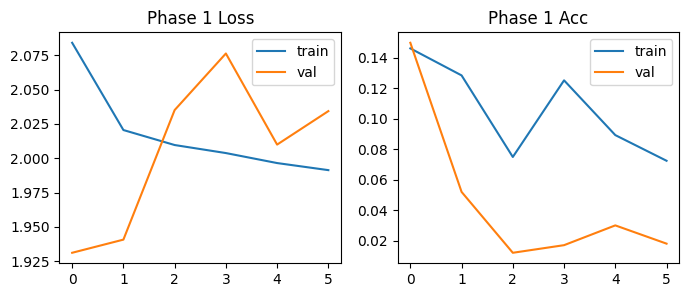

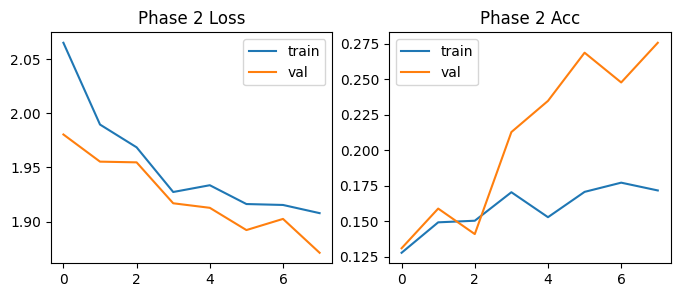

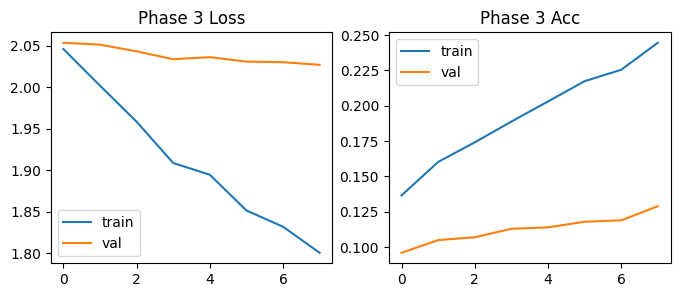

Final test accuracy: 12.67%


In [ ]:
# ── IMPORTS & CONFIG ───────────────────────────────────────────────────────────
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, CSVLogger
from tensorflow.keras.applications import EfficientNetB3
from sklearn.utils import class_weight
import matplotlib.pyplot as plt

# adjust these to your DataFrames
# train_df, val_df, test_df each must have columns ['image_path','mask_path','dx_int']
# dx_int ∈ {0,…,6}

IMG_SIZE   = (224,224)
BATCH_SIZE = 32
WORK_DIR   = "transfer_3phases_effnetb3"
CKPT_DIR   = os.path.join(WORK_DIR,"checkpoints")
os.makedirs(CKPT_DIR, exist_ok=True)

# ── 1) COMPUTE CLASS WEIGHTS ───────────────────────────────────────────────────
y = train_df.dx_int.values
w = class_weight.compute_class_weight("balanced", classes=np.unique(y), y=y)
CLASS_WEIGHTS = dict(enumerate(w))

AUTOTUNE = tf.data.AUTOTUNE

# ── 2) PREPROCESSING & AUGMENTATION ─────────────────────────────────────────────
def load_resize(path, channels):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=channels, expand_animations=False)
    img = tf.image.resize(img, IMG_SIZE)
    return img/255.0

def prep_rgb(path, label):
    return load_resize(path,3), label

def prep_mask_as_rgb(path, label):
    m = load_resize(path,1)
    m = tf.cast(m>0.5, tf.float32)
    return tf.tile(m,[1,1,3]), label

def prep_masked(rgb_path, mask_path, label):
    rgb = load_resize(rgb_path,3)
    m   = load_resize(mask_path,1)
    m   = tf.cast(m>0.5, tf.float32)
    # overlay = elementwise multiply
    return rgb * m, label

def augment(inputs, label):
    # inputs is tuple of three image tensors: (rgb, mask_rgb, masked)
    rgb, mask_rgb, masked = inputs
    data = tf.concat([rgb, mask_rgb, masked], axis=-1)
    data = tf.image.random_flip_left_right(data)
    data = tf.image.random_flip_up_down(data)
    data = tf.image.random_brightness(data, 0.1)
    # split back
    r, mr, m = tf.split(data, [3,3,3], axis=-1)
    return (r, mr, m), label

# ── 3) BUILD TF DATASETS ───────────────────────────────────────────────────────
def make_ds_rgb(df):
    return (tf.data.Dataset.from_tensor_slices((df.image_path, df.dx_int))
            .map(prep_rgb, AUTOTUNE)
            .batch(BATCH_SIZE).prefetch(AUTOTUNE))

def make_ds_maskrgb(df):
    return (tf.data.Dataset.from_tensor_slices((df.mask_path, df.dx_int))
            .map(prep_mask_as_rgb, AUTOTUNE)
            .batch(BATCH_SIZE).prefetch(AUTOTUNE))

def make_ds_masked(df):
    return (tf.data.Dataset.from_tensor_slices((df.image_path, df.mask_path, df.dx_int))
            .map(prep_masked, AUTOTUNE)
            .batch(BATCH_SIZE).prefetch(AUTOTUNE))

train_rgb     = make_ds_rgb(train_df)
train_maskrgb = make_ds_maskrgb(train_df)
train_masked  = make_ds_masked(train_df)
val_rgb       = make_ds_rgb(val_df)
val_maskrgb   = make_ds_maskrgb(val_df)
val_masked    = make_ds_masked(val_df)
test_rgb      = make_ds_rgb(test_df)
test_maskrgb  = make_ds_maskrgb(test_df)
test_masked   = make_ds_masked(test_df)

# zip into 3‑input tuples, augment on train
train_multi = tf.data.Dataset.zip((train_rgb, train_maskrgb, train_masked))\
    .map(lambda a,b,c: ((a[0],b[0],c[0]), a[1]), AUTOTUNE)\
    .map(augment, AUTOTUNE)\
    .shuffle(500).prefetch(AUTOTUNE)

val_multi = tf.data.Dataset.zip((val_rgb, val_maskrgb, val_masked))\
    .map(lambda a,b,c: ((a[0],b[0],c[0]), a[1]), AUTOTUNE).prefetch(AUTOTUNE)

test_multi = tf.data.Dataset.zip((test_rgb, test_maskrgb, test_masked))\
    .map(lambda a,b,c: ((a[0],b[0],c[0]), a[1]), AUTOTUNE).prefetch(AUTOTUNE)

# ── 4) MODEL FACTORY (shared‐backbone triplet‐branch) ─────────────────────────
def build_model(n_classes):
    in1 = layers.Input((*IMG_SIZE,3), name="rgb")
    in2 = layers.Input((*IMG_SIZE,3), name="maskrgb")
    in3 = layers.Input((*IMG_SIZE,3), name="masked")

    # shared EfficientNetB3 backbone
    backbone = EfficientNetB3(include_top=False, weights="imagenet", pooling=None)
    backbone.trainable = False

    f1 = backbone(in1)
    f2 = backbone(in2)
    f3 = backbone(in3)

    p1 = layers.GlobalAveragePooling2D()(f1)
    p2 = layers.GlobalAveragePooling2D()(f2)
    p3 = layers.GlobalAveragePooling2D()(f3)

    x = layers.Concatenate()([p1,p2,p3])
    x = layers.Dense(512, activation="relu",
                     kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
    x = layers.Dropout(0.5)(x)
    out = layers.Dense(n_classes, activation="softmax")(x)

    return models.Model([in1,in2,in3], out, name="multi_effnetb3")

# ── 5) THREE‐PHASE FINE‐TUNING ────────────────────────────────────────────────
n_classes = len(np.unique(y))
model = build_model(n_classes)

def make_cbs(phase):
    return [
      ModelCheckpoint(f"{CKPT_DIR}/phase{phase}.weights.h5",
                      monitor="val_loss", save_best_only=True, save_weights_only=True),
      ReduceLROnPlateau("val_loss", factor=0.5, patience=3, verbose=1),
      EarlyStopping("val_loss", patience=5, restore_best_weights=True, verbose=1),
      CSVLogger(f"{WORK_DIR}/phase{phase}.log.csv")
    ]

# Phase 1: head only
for layer in model.layers:
    layer.trainable = layer.name.startswith(("dense","dropout"))
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss="sparse_categorical_crossentropy", metrics=["accuracy"])
h1 = model.fit(train_multi, validation_data=val_multi,
               epochs=8, callbacks=make_cbs(1),
               class_weight=CLASS_WEIGHTS, verbose=2)

# Phase 2: unfreeze last 30 layers of backbone
backbone = model.get_layer("efficientnetb3")
for layer in backbone.layers[-30:]:
    layer.trainable = True
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss="sparse_categorical_crossentropy", metrics=["accuracy"])
h2 = model.fit(train_multi, validation_data=val_multi,
               epochs=8, callbacks=make_cbs(2),
               class_weight=CLASS_WEIGHTS, verbose=2)

# Phase 3: unfreeze entire backbone
for layer in backbone.layers:
    layer.trainable = True
model.compile(optimizer=tf.keras.optimizers.Adam(1e-6),
              loss="sparse_categorical_crossentropy", metrics=["accuracy"])
h3 = model.fit(train_multi, validation_data=val_multi,
               epochs=8, callbacks=make_cbs(3),
               class_weight=CLASS_WEIGHTS, verbose=2)

# ── 6) PLOT PER‑PHASE CURVES ──────────────────────────────────────────────────
def plot_hist(h, phase):
    plt.figure(figsize=(8,3))
    plt.subplot(1,2,1)
    plt.plot(h.history['loss'],label='train'); plt.plot(h.history['val_loss'],label='val')
    plt.title(f'Phase {phase} Loss'); plt.legend()
    plt.subplot(1,2,2)
    plt.plot(h.history['accuracy'],label='train'); plt.plot(h.history['val_accuracy'],label='val')
    plt.title(f'Phase {phase} Acc'); plt.legend()
    plt.show()

plot_hist(h1,1)
plot_hist(h2,2)
plot_hist(h3,3)

# ── 7) FINAL EVALUATION ───────────────────────────────────────────────────────
loss, acc = model.evaluate(test_multi, verbose=0)
print(f"Final test accuracy: {acc:.2%}")


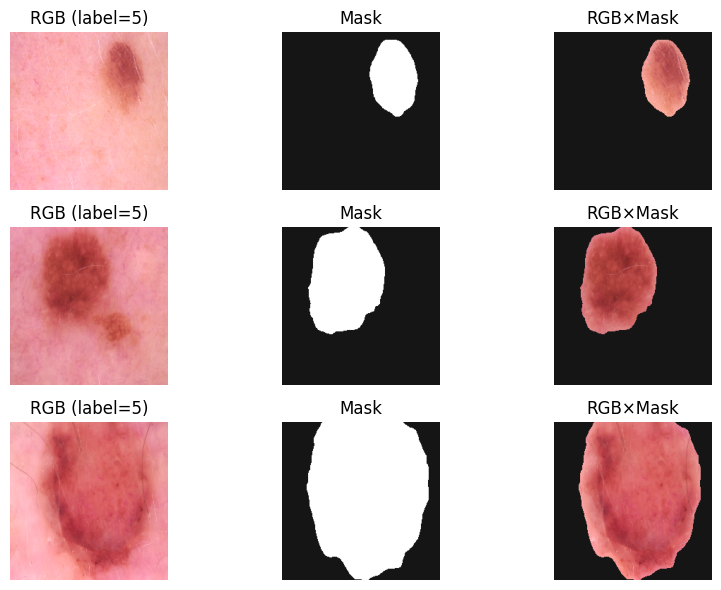

In [ ]:
import matplotlib.pyplot as plt

# grab one batch from your 3-input dataset
for batch in train_multi.take(1):
    (rgb_batch, mask_batch, masked_batch), labels = batch
    # show first 3 samples
    plt.figure(figsize=(9,6))
    for i in range(3):
        # RGB
        plt.subplot(3,3,1 + i*3)
        plt.imshow(rgb_batch[i].numpy())
        plt.title(f"RGB (label={labels[i].numpy()})")
        plt.axis("off")
        # Mask as RGB
        plt.subplot(3,3,2 + i*3)
        plt.imshow(mask_batch[i].numpy().squeeze(), cmap="gray")
        plt.title("Mask")
        plt.axis("off")
        # Masked = rgb * mask
        plt.subplot(3,3,3 + i*3)
        plt.imshow(masked_batch[i].numpy())
        plt.title("RGB×Mask")
        plt.axis("off")
    plt.tight_layout()
    break


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "multi_resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ rgb (InputLayer)    │ (None, 224, 224,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ maskrgb             │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masked (InputLayer) │ (None, 224, 224,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ rgb[0][0],        │
│ (Functional)        │ 2048)             │            │ maskrgb[0][0],    │
│                     │                   │            │ masked[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[1][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[2][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 6144)      │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ global_average_p… │
│                     │                   │            │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 512)       │  3,146,240 │ concatenate_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 512)       │          0 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 7)         │      3,591 │ dropout_4[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 26,737,543 (102.00 MB)

 Trainable params: 3,149,831 (12.02 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/8

Epoch 1: val_loss improved from inf to 2.10753, saving model to transfer_3phases_resnet50/checkpoints/phase1.weights.h5
251/251 - 122s - 488ms/step - accuracy: 0.1493 - loss: 2.1246 - val_accuracy: 0.1039 - val_loss: 2.1075 - learning_rate: 1.0000e-04
Epoch 2/8

Epoch 2: val_loss improved from 2.10753 to 1.99878, saving model to transfer_3phases_resnet50/checkpoints/phase1.weights.h5
251/251 - 66s - 263ms/step - accuracy: 0.1415 - loss: 1.9514 - val_accuracy: 0.0400 - val_loss: 1.9988 - learning_rate: 1.0000e-04
Epoch 3/8

Epoch 3: val_loss improved from 1.99878 to 1.90518, saving model to transfer_3phases_resnet50/checkpoints/phase1.weights.h5
251/251 - 66s - 264ms/step - accuracy: 0.1181 - loss: 1.8947 - val_accuracy: 0.1379 - val_loss: 1.9052 - learning_rate: 1.0000e-04
Epoch 4/8

Epoch 4: val_loss did not improve from 1.90518
251/251 - 65s - 260ms/step - accuracy: 0.1449 - loss: 1.8765 - val_accuracy: 0.1229 - val_loss: 1.9297 - learning_rate: 1.0000e-04
Epoch 5/8

Epoch

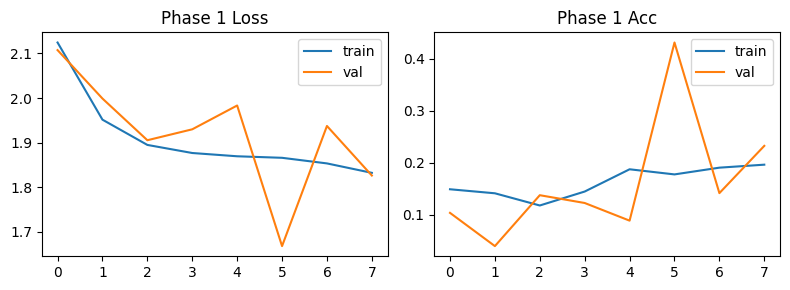

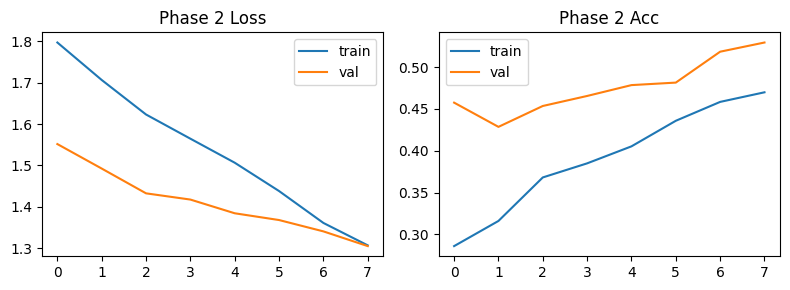

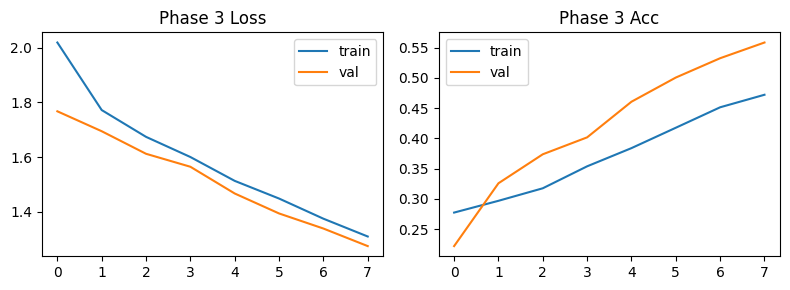


Final test accuracy: 56.89%


In [ ]:
# # ── IMPORTS & GLOBAL CONFIG ───────────────────────────────────────────────────
# import os
# import numpy as np
# import tensorflow as tf
# from tensorflow.keras import layers, models
# from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, CSVLogger
# from tensorflow.keras.applications import ResNet50
# from sklearn.utils import class_weight
# import matplotlib.pyplot as plt

# # adjust these to your DataFrames
# # train_df, val_df, test_df each must have columns ['image_path','mask_path','dx_int']
# IMG_SIZE   = (224, 224)
# BATCH_SIZE = 32
# WORK_DIR   = "transfer_3phases_resnet50"
# CKPT_DIR   = os.path.join(WORK_DIR, "checkpoints")
# os.makedirs(CKPT_DIR, exist_ok=True)

# # compute class weights to counter dataset imbalance
# y = train_df.dx_int.values
# w = class_weight.compute_class_weight("balanced", classes=np.unique(y), y=y)
# CLASS_WEIGHTS = dict(enumerate(w))

# AUTOTUNE = tf.data.AUTOTUNE


# # ── 1) PREPROCESSING & AUGMENTATION ────────────────────────────────────────────
# def load_resize(path, channels):
#     """Load an image from disk and resize it to IMG_SIZE, normalize to [0,1]."""
#     img = tf.io.read_file(path)
#     img = tf.image.decode_image(img, channels=channels, expand_animations=False)
#     img = tf.image.resize(img, IMG_SIZE)
#     return img / 255.0

# def prep_rgb(path, label):
#     """RGB branch."""
#     return load_resize(path, 3), label

# def prep_mask_as_rgb(path, label):
#     """Binarize mask to 0/1 then tile to 3 channels."""
#     m = load_resize(path, 1)
#     m = tf.cast(m > 0.5, tf.float32)
#     m3 = tf.tile(m, [1,1,3])
#     return m3, label

# def prep_masked(rgb_path, mask_path, label):
#     """Elementwise multiply rgb * mask (still 3-ch)."""
#     rgb = load_resize(rgb_path, 3)
#     m   = load_resize(mask_path, 1)
#     m   = tf.cast(m > 0.5, tf.float32)
#     return rgb * m, label

# def augment(inputs, label):
#     """Apply identical random flips/brightness to all three inputs."""
#     rgb, maskrgb, masked = inputs
#     x = tf.concat([rgb, maskrgb, masked], axis=-1)
#     x = tf.image.random_flip_left_right(x)
#     x = tf.image.random_flip_up_down(x)
#     x = tf.image.random_brightness(x, 0.1)
#     # split back
#     r, mr, m = tf.split(x, [3,3,3], axis=-1)
#     return (r, mr, m), label


# # ── 2) BUILD TF DATASETS ───────────────────────────────────────────────────────
# def make_ds_rgb(df):
#     return (tf.data.Dataset
#             .from_tensor_slices((df.image_path, df.dx_int))
#             .map(prep_rgb, AUTOTUNE)
#             .batch(BATCH_SIZE).prefetch(AUTOTUNE))

# def make_ds_maskrgb(df):
#     return (tf.data.Dataset
#             .from_tensor_slices((df.mask_path, df.dx_int))
#             .map(prep_mask_as_rgb, AUTOTUNE)
#             .batch(BATCH_SIZE).prefetch(AUTOTUNE))

# def make_ds_masked(df):
#     return (tf.data.Dataset
#             .from_tensor_slices((df.image_path, df.mask_path, df.dx_int))
#             .map(prep_masked, AUTOTUNE)
#             .batch(BATCH_SIZE).prefetch(AUTOTUNE))

# # raw datasets
# train_rgb     = make_ds_rgb(train_df)
# train_maskrgb = make_ds_maskrgb(train_df)
# train_masked  = make_ds_masked(train_df)
# val_rgb       = make_ds_rgb(val_df)
# val_maskrgb   = make_ds_maskrgb(val_df)
# val_masked    = make_ds_masked(val_df)
# test_rgb      = make_ds_rgb(test_df)
# test_maskrgb  = make_ds_maskrgb(test_df)
# test_masked   = make_ds_masked(test_df)

# # zip into 3-input tuples, augment only on train
# train_multi = (tf.data.Dataset.zip((train_rgb, train_maskrgb, train_masked))
#                .map(lambda a, b, c: ((a[0], b[0], c[0]), a[1]), AUTOTUNE)
#                .map(augment, AUTOTUNE)
#                .shuffle(500).prefetch(AUTOTUNE))

# val_multi = (tf.data.Dataset.zip((val_rgb, val_maskrgb, val_masked))
#              .map(lambda a, b, c: ((a[0], b[0], c[0]), a[1]), AUTOTUNE)
#              .prefetch(AUTOTUNE))

# test_multi = (tf.data.Dataset.zip((test_rgb, test_maskrgb, test_masked))
#               .map(lambda a, b, c: ((a[0], b[0], c[0]), a[1]), AUTOTUNE)
#               .prefetch(AUTOTUNE))


# # ── 3) MODEL FACTORY (shared ResNet50 backbone) ────────────────────────────────
# def build_multi_resnet50(n_classes):
#     # three 3-channel inputs
#     in_rgb     = layers.Input((*IMG_SIZE, 3), name="rgb")
#     in_maskrgb = layers.Input((*IMG_SIZE, 3), name="maskrgb")
#     in_masked  = layers.Input((*IMG_SIZE, 3), name="masked")
#     # share one ResNet50 (frozen)
#     base = ResNet50(include_top=False, weights="imagenet", pooling=None)
#     base.trainable = False
#     # extract features
#     f1 = base(in_rgb)
#     f2 = base(in_maskrgb)
#     f3 = base(in_masked)
#     # pool & concat
#     p1 = layers.GlobalAveragePooling2D()(f1)
#     p2 = layers.GlobalAveragePooling2D()(f2)
#     p3 = layers.GlobalAveragePooling2D()(f3)
#     x  = layers.Concatenate()([p1, p2, p3])
#     # small head: 3×2048→512→7
#     x  = layers.Dense(512, activation="relu",
#                       kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
#     x  = layers.Dropout(0.5)(x)
#     out = layers.Dense(n_classes, activation="softmax")(x)
#     return models.Model([in_rgb, in_maskrgb, in_masked], out, name="multi_resnet50")

# n_classes = len(np.unique(y))
# model = build_multi_resnet50(n_classes)
# model.summary()


# # ── 4) THREE-PHASE FINE-TUNING ────────────────────────────────────────────────
# def make_cbs(phase):
#     return [
#       ModelCheckpoint(f"{CKPT_DIR}/phase{phase}.weights.h5",
#                       monitor="val_loss",
#                       save_best_only=True,
#                       save_weights_only=True,
#                       verbose=1),
#       ReduceLROnPlateau("val_loss", factor=0.5, patience=3, verbose=1),
#       EarlyStopping("val_loss", patience=5, restore_best_weights=True, verbose=1),
#       CSVLogger(f"{WORK_DIR}/phase{phase}.log.csv")
#     ]

# # — Phase 1: train only the new head (layers named “dense” or “dropout”)
# for layer in model.layers:
#     layer.trainable = layer.name.startswith(("dense","dropout"))
# model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
#               loss="sparse_categorical_crossentropy",
#               metrics=["accuracy"])
# h1 = model.fit(train_multi, validation_data=val_multi,
#                epochs=8, callbacks=make_cbs(1),
#                class_weight=CLASS_WEIGHTS, verbose=2)

# # — Phase 2: unfreeze the last ResNet50 blocks (say last 20 layers)
# backbone = model.get_layer("resnet50")
# for layer in backbone.layers[-20:]:
#     layer.trainable = True
# model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
#               loss="sparse_categorical_crossentropy",
#               metrics=["accuracy"])
# h2 = model.fit(train_multi, validation_data=val_multi,
#                epochs=8, callbacks=make_cbs(2),
#                class_weight=CLASS_WEIGHTS, verbose=2)

# # — Phase 3: unfreeze the full backbone
# for layer in backbone.layers:
#     layer.trainable = True
# model.compile(optimizer=tf.keras.optimizers.Adam(1e-6),
#               loss="sparse_categorical_crossentropy",
#               metrics=["accuracy"])
# h3 = model.fit(train_multi, validation_data=val_multi,
#                epochs=8, callbacks=make_cbs(3),
#                class_weight=CLASS_WEIGHTS, verbose=2)


# # ── 5) PLOT PER-PHASE CURVES ───────────────────────────────────────────────────
# def plot_hist(h, phase):
#     plt.figure(figsize=(8,3))
#     plt.subplot(1,2,1)
#     plt.plot(h.history["loss"],   label="train")
#     plt.plot(h.history["val_loss"], label="val")
#     plt.title(f"Phase {phase} Loss");   plt.legend()
#     plt.subplot(1,2,2)
#     plt.plot(h.history["accuracy"],   label="train")
#     plt.plot(h.history["val_accuracy"], label="val")
#     plt.title(f"Phase {phase} Acc");    plt.legend()
#     plt.tight_layout(); plt.show()

# plot_hist(h1, 1)
# plot_hist(h2, 2)
# plot_hist(h3, 3)


# # ── 6) FINAL EVALUATION ───────────────────────────────────────────────────────
# loss, acc = model.evaluate(test_multi, verbose=0)
# print(f"\nFinal test accuracy: {acc:.2%}")


In [ ]:
# ── IMPORTS & CONFIG ─────────────────────────────────────────────────────────
import os, numpy as np, tensorflow as tf, matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, CSVLogger
from tensorflow.keras.applications import ResNet50
from sklearn.utils import class_weight

IMG_SIZE   = (224,224)
BATCH_SIZE = 32
WORK_DIR   = "phase1_rgb_only"
CKPT_DIR   = os.path.join(WORK_DIR,"checkpoints")
os.makedirs(CKPT_DIR, exist_ok=True)

# compute class weights
y = train_df.dx_int.values
from sklearn.utils.class_weight import compute_class_weight

w = compute_class_weight(
    "balanced",
    classes=np.unique(y),
    y=y
)

CLASS_WEIGHTS = dict(enumerate(w))
AUTOTUNE = tf.data.AUTOTUNE

# ── DATASET (RGB only) ────────────────────────────────────────────────────────
def load_rgb(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, IMG_SIZE)/255.0
    return img, label

def make_ds_rgb(df, augment=False):
    ds = tf.data.Dataset.from_tensor_slices((df.image_path.values, df.dx_int.values))
    ds = ds.map(load_rgb, AUTOTUNE)
    if augment:
        ds = ds.map(lambda x,y: (tf.image.random_flip_left_right(x), y), AUTOTUNE) \
               .map(lambda x,y: (tf.image.random_brightness(x,0.1), y), AUTOTUNE)
    return ds.shuffle(500).batch(BATCH_SIZE).prefetch(AUTOTUNE)

train_rgb = make_ds_rgb(train_df, augment=True)
val_rgb   = make_ds_rgb(val_df)
test_rgb  = make_ds_rgb(test_df)

# ── MODEL (RGB only) ──────────────────────────────────────────────────────────
def build_rgb_model(n_classes):
    inp  = layers.Input((*IMG_SIZE,3), name="rgb")
    base = ResNet50(include_top=False, weights="imagenet", pooling=None)
    base.trainable = False

    x = base(inp)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation="relu",
                     kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
    x = layers.Dropout(0.5)(x)
    out = layers.Dense(n_classes, activation="softmax")(x)
    return models.Model(inp, out, name="rgb_only")

model = build_rgb_model(len(np.unique(y)))
model.summary()

# ── 3-PHASE FINE-TUNING (RGB) ─────────────────────────────────────────────────
def make_cbs(phase):
    return [
        ModelCheckpoint(
            os.path.join(CKPT_DIR, f"phase{phase}.weights.h5"),
            monitor="val_loss",
            save_best_only=True,
            save_weights_only=True,
            verbose=1
        ),
        ReduceLROnPlateau("val_loss", factor=0.5, patience=3, verbose=1),
        EarlyStopping("val_loss", patience=5, restore_best_weights=True, verbose=1),
        CSVLogger(f"{WORK_DIR}/phase{phase}.log.csv")
    ]

# Freeze only the head layers for RGB-only
#Unfreeze only conv5_x layers of ResNet50 + your head layers
backbone = model.get_layer("resnet50")
for layer in backbone.layers:
    # conv5_.* are the top‐level feature extractors in ResNet50
    layer.trainable = layer.name.startswith("conv5_")
for layer in model.layers:
    # ensure your Dense/Dropout head remains trainable
    if layer.name.startswith(("dense","dropout")):
        layer.trainable = True

# 2) Compile with the same learning rate you used in Phase 1
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# 3) Callbacks (filenames must end in .weights.h5 when save_weights_only=True)
callbacks = [
    ModelCheckpoint(
        os.path.join(CKPT_DIR, "phase1_rev.weights.h5"),
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=3, verbose=1
    ),
    EarlyStopping(
        monitor="val_loss", patience=5, restore_best_weights=True, verbose=1
    ),
    CSVLogger(
        os.path.join(WORK_DIR, "phase1_rev.log.csv")
    )
]

# 4) Train on RGB-only data to warm up conv5_x + your head
h1_rev = model.fit(
    train_rgb,           # RGB‐only training dataset
    validation_data=val_rgb,
    epochs=12,
    callbacks=callbacks,
    class_weight=CLASS_WEIGHTS,
    verbose=2
)

# 5) Quick evaluation on the hold-out set
loss, acc = model.evaluate(test_rgb, verbose=0)
print(f"→ Phase 1_rev (head+conv5) test accuracy: {acc:.2%}")




Model: "rgb_only"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rgb (InputLayer)                │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_16     │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,640,391 (94.00 MB)

 Trainable params: 1,052,679 (4.02 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/12

Epoch 1: val_loss improved from inf to 2.25231, saving model to phase1_rgb_only/checkpoints/phase1_rev.weights.h5
251/251 - 55s - 218ms/step - accuracy: 0.2353 - loss: 2.0601 - val_accuracy: 0.1119 - val_loss: 2.2523 - learning_rate: 1.0000e-04
Epoch 2/12

Epoch 2: val_loss did not improve from 2.25231
251/251 - 16s - 62ms/step - accuracy: 0.2662 - loss: 1.9332 - val_accuracy: 0.0440 - val_loss: 2.4180 - learning_rate: 1.0000e-04
Epoch 3/12

Epoch 3: val_loss did not improve from 2.25231
251/251 - 16s - 63ms/step - accuracy: 0.2144 - loss: 1.8753 - val_accuracy: 0.0140 - val_loss: 6.8288 - learning_rate: 1.0000e-04
Epoch 4/12

Epoch 4: val_loss improved from 2.25231 to 1.74928, saving model to phase1_rgb_only/checkpoints/phase1_rev.weights.h5
251/251 - 17s - 68ms/step - accuracy: 0.2625 - loss: 1.8236 - val_accuracy: 0.0280 - val_loss: 1.7493 - learning_rate: 1.0000e-04
Epoch 5/12

Epoch 5: val_loss did not improve from 1.74928
251/251 - 15s - 61ms/step - accuracy: 0.2526 -

Model: "rgb_head_only"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_17     │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,640,391 (94.00 MB)

 Trainable params: 1,052,679 (4.02 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/12

Epoch 1: val_loss improved from inf to 1.78414, saving model to phase1_rgb_only/checkpoints/phase1_rgb_head.weights.h5
251/251 - 54s - 216ms/step - accuracy: 0.1198 - loss: 2.0559 - val_accuracy: 0.6663 - val_loss: 1.7841 - learning_rate: 1.0000e-04
Epoch 2/12

Epoch 2: val_loss did not improve from 1.78414
251/251 - 30s - 121ms/step - accuracy: 0.1279 - loss: 2.0192 - val_accuracy: 0.0509 - val_loss: 1.8422 - learning_rate: 1.0000e-04
Epoch 3/12

Epoch 3: val_loss did not improve from 1.78414
251/251 - 30s - 120ms/step - accuracy: 0.1198 - loss: 1.9918 - val_accuracy: 0.0170 - val_loss: 1.9216 - learning_rate: 1.0000e-04
Epoch 4/12

Epoch 4: val_loss did not improve from 1.78414

Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
251/251 - 30s - 121ms/step - accuracy: 0.1151 - loss: 1.9732 - val_accuracy: 0.2448 - val_loss: 1.8879 - learning_rate: 1.0000e-04
Epoch 5/12

Epoch 5: val_loss did not improve from 1.78414
251/251 - 30s - 120ms/step - acc

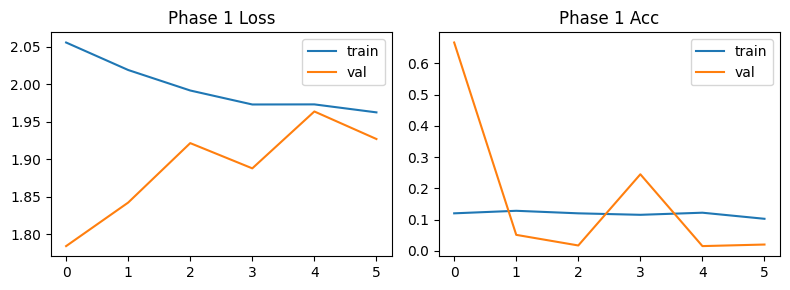

Phase 1 (RGB‐only) test accuracy: 66.37%


In [ ]:
# ── IMPORTS & CONFIG ─────────────────────────────────────────────────────────
import os, numpy as np, tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, CSVLogger
from tensorflow.keras.applications import ResNet50
from sklearn.utils import class_weight

# adjust to your setup:
# train_df, val_df, test_df each have ['image_path','dx_int']
IMG_SIZE   = (224,224)
BATCH_SIZE = 32
WORK_DIR   = "phase1_rgb_only"
CKPT_DIR   = os.path.join(WORK_DIR, "checkpoints")
os.makedirs(CKPT_DIR, exist_ok=True)

# compute class weights
y = train_df.dx_int.values
w = class_weight.compute_class_weight("balanced", classes=np.unique(y), y=y)
CLASS_WEIGHTS = dict(enumerate(w))

AUTOTUNE = tf.data.AUTOTUNE

# ── 1) BUILD RGB-ONLY DATASETS ───────────────────────────────────────────────
def load_resize_rgb(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    return img/255.0, label

# base train/val/test (no mask)
train_rgb = (tf.data.Dataset
    .from_tensor_slices((train_df.image_path.values, train_df.dx_int.values))
    .map(load_resize_rgb, num_parallel_calls=AUTOTUNE)
)
val_rgb = (tf.data.Dataset
    .from_tensor_slices((val_df.image_path.values, val_df.dx_int.values))
    .map(load_resize_rgb, num_parallel_calls=AUTOTUNE)
)
test_rgb = (tf.data.Dataset
    .from_tensor_slices((test_df.image_path.values, test_df.dx_int.values))
    .map(load_resize_rgb, num_parallel_calls=AUTOTUNE)
)

# heavy on-the-fly augmentation for train
augmenter = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomBrightness(factor=0.1),
])
train_rgb_aug = (train_rgb
    .map(lambda img, lbl: (augmenter(img, training=True), lbl),
         num_parallel_calls=AUTOTUNE)
    .shuffle(1000)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

val_rgb = val_rgb.batch(BATCH_SIZE).prefetch(AUTOTUNE)
test_rgb = test_rgb.batch(BATCH_SIZE).prefetch(AUTOTUNE)

# ── 2) BUILD & COMPILE RGB-ONLY MODEL ────────────────────────────────────────
def build_rgb_head(n_classes):
    # frozen ResNet50 backbone
    base = ResNet50(include_top=False, weights="imagenet",
                    input_shape=(*IMG_SIZE,3))
    base.trainable = False

    inp = layers.Input((*IMG_SIZE,3))
    x   = base(inp, training=False)
    x   = layers.GlobalAveragePooling2D()(x)
    x   = layers.Dense(512, activation="relu")(x)
    x   = layers.Dropout(0.3)(x)
    out = layers.Dense(n_classes, activation="softmax")(x)

    model = models.Model(inp, out, name="rgb_head_only")
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

n_classes = len(np.unique(y))
model = build_rgb_head(n_classes)
model.summary()

# ── 3) CALLBACKS ─────────────────────────────────────────────────────────────
callbacks = [
    ModelCheckpoint(os.path.join(CKPT_DIR,"phase1_rgb_head.weights.h5"),
                    monitor="val_loss", save_best_only=True,
                    save_weights_only=True, verbose=1),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1),
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1),
    CSVLogger(os.path.join(WORK_DIR,"phase1_rgb_head.log.csv"))
]

# ── 4) TRAIN PHASE 1 ─────────────────────────────────────────────────────────
history = model.fit(
    train_rgb_aug,
    validation_data=val_rgb,
    epochs=12,
    callbacks=callbacks,
    class_weight=CLASS_WEIGHTS,
    verbose=2
)

# ── 5) PLOT & EVALUATE ──────────────────────────────────────────────────────
import matplotlib.pyplot as plt
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="val")
plt.title("Phase 1 Loss"); plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history["accuracy"], label="train")
plt.plot(history.history["val_accuracy"], label="val")
plt.title("Phase 1 Acc"); plt.legend()
plt.tight_layout(); plt.show()

loss, acc = model.evaluate(test_rgb, verbose=0)
print(f"Phase 1 (RGB‐only) test accuracy: {acc:.2%}")


In [ ]:
# ── RGB‐ONLY BASELINE TRANSFER LEARNING ────────────────────────────────────────
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import (
    ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, CSVLogger
)
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

from sklearn.utils import class_weight

# — adjust these to your environment —
# assume train_df, val_df, test_df each has columns ['image_path','dx_int']
IMG_SIZE   = (224, 224)
BATCH_SIZE = 32
WORK_DIR   = "transfer_rgb_baseline"
CKPT_DIR   = os.path.join(WORK_DIR, "checkpoints")
os.makedirs(CKPT_DIR, exist_ok=True)

# ── 1) COMPUTE CLASS WEIGHTS ─────────────────────────────────────────────────
y = train_df.dx_int.values
w = class_weight.compute_class_weight("balanced",
                                      classes=np.unique(y),
                                      y=y)
CLASS_WEIGHTS = dict(enumerate(w))

AUTOTUNE = tf.data.AUTOTUNE

# ── 2) DATASET PREPARATION ───────────────────────────────────────────────────
def load_and_preprocess(path, label):
    """Load image, resize, apply ResNet-specific preprocessing."""
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = preprocess_input(img)             # scales pixel values for ResNet
    return img, label

def augment(img, label):
    """Simple on-the-fly augmentation to improve generalization."""
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_flip_up_down(img)
    img = tf.image.random_brightness(img, 0.1)
    return img, label

def make_ds(df, training=False):
    ds = tf.data.Dataset.from_tensor_slices((df.image_path.values,
                                             df.dx_int.values))
    ds = ds.map(load_and_preprocess, num_parallel_calls=AUTOTUNE)
    if training:
        ds = ds.map(augment, num_parallel_calls=AUTOTUNE)
        ds = ds.shuffle(1000)
    return ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

train_ds = make_ds(train_df, training=True)
val_ds   = make_ds(val_df,   training=False)
test_ds  = make_ds(test_df,  training=False)

# ── 3) MODEL FACTORY ──────────────────────────────────────────────────────────
def build_rgb_model(n_classes):
    """
    Returns a ResNet50-based model with:
      - frozen backbone
      - small head: GlobalPool → Dense(512) → Dropout → Dense(n_classes)
    """
    base = ResNet50(include_top=False,
                    weights="imagenet",
                    input_shape=(*IMG_SIZE, 3),
                    pooling=None)
    base.trainable = False  # freeze all pre-trained layers

    x = base.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation="relu",
                     kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(n_classes, activation="softmax")(x)

    return models.Model(inputs=base.input, outputs=outputs, name="rgb_baseline")

model = build_rgb_model(len(np.unique(y)))
model.summary()

# ── 4) CALLBACKS ─────────────────────────────────────────────────────────────
def get_callbacks(phase):
    """Common callbacks for each fine-tuning phase."""
    return [
        ModelCheckpoint(
            filepath=os.path.join(CKPT_DIR, f"phase{phase}.weights.h5"),
            monitor="val_loss", save_best_only=True,
            save_weights_only=True, verbose=1
        ),
        ReduceLROnPlateau(
            monitor="val_loss", factor=0.5,
            patience=3, verbose=1
        ),
        EarlyStopping(
            monitor="val_loss", patience=5,
            restore_best_weights=True, verbose=1
        ),
        CSVLogger(
            filename=os.path.join(WORK_DIR, f"phase{phase}.log.csv")
        )
    ]

# ── 5) THREE‐PHASE FINE‐TUNING ────────────────────────────────────────────────
# Phase 1: train new head only
for layer in model.layers:
    layer.trainable = layer.name.startswith(("dense", "dropout"))
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)
h1 = model.fit(
    train_ds, validation_data=val_ds,
    epochs=8,
    callbacks=get_callbacks(1),
    class_weight=CLASS_WEIGHTS,
    verbose=2
)

# Phase 2: unfreeze last ResNet block(s)
for layer in model.layers:
    # e.g. layers in the final conv block often start with "conv5_"
    if layer.name.startswith("conv5_") or layer.name.startswith(("dense", "dropout")):
        layer.trainable = True
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)
h2 = model.fit(
    train_ds, validation_data=val_ds,
    epochs=8,
    callbacks=get_callbacks(2),
    class_weight=CLASS_WEIGHTS,
    verbose=2
)

# Phase 3: fine‐tune entire backbone
for layer in model.layers:
    layer.trainable = True
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-6),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)
h3 = model.fit(
    train_ds, validation_data=val_ds,
    epochs=8,
    callbacks=get_callbacks(3),
    class_weight=CLASS_WEIGHTS,
    verbose=2
)

# ── 6) FINAL EVALUATION ───────────────────────────────────────────────────────
loss, acc = model.evaluate(test_ds, verbose=0)
print(f"RGB‐only baseline test accuracy: {acc:.2%}")

# **What this does:**
# - **Prepares** a simple RGB‐only pipeline with on‐the‐fly flips & jitter
# - **Builds** a ResNet50 backbone + small classification head
# - **Fine‐tunes** in three stages: head‐only → partial unfreeze → full unfreeze
# - **Logs** training/validation metrics and checkpoints after each phase



94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "rgb_baseline"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast (Cast)         │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ cast[0][0]        │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c

 Total params: 24,640,391 (94.00 MB)

 Trainable params: 1,052,679 (4.02 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/8

Epoch 1: val_loss improved from inf to 1.18984, saving model to transfer_rgb_baseline/checkpoints/phase1.weights.h5
251/251 - 544s - 2s/step - accuracy: 0.3922 - loss: 2.0036 - val_accuracy: 0.6184 - val_loss: 1.1898 - learning_rate: 1.0000e-04
Epoch 2/8

Epoch 2: val_loss improved from 1.18984 to 1.00340, saving model to transfer_rgb_baseline/checkpoints/phase1.weights.h5
251/251 - 17s - 69ms/step - accuracy: 0.5543 - loss: 1.3241 - val_accuracy: 0.6663 - val_loss: 1.0034 - learning_rate: 1.0000e-04
Epoch 3/8

Epoch 3: val_loss did not improve from 1.00340
251/251 - 17s - 66ms/step - accuracy: 0.5836 - loss: 1.1665 - val_accuracy: 0.6374 - val_loss: 1.0499 - learning_rate: 1.0000e-04
Epoch 4/8

Epoch 4: val_loss did not improve from 1.00340
251/251 - 17s - 66ms/step - accuracy: 0.6090 - loss: 1.0723 - val_accuracy: 0.6543 - val_loss: 1.0149 - learning_rate: 1.0000e-04
Epoch 5/8

Epoch 5: val_loss improved from 1.00340 to 0.98415, saving model to transfer_rgb_baseline/checkp

Model: "3branch_resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ rgb (InputLayer)    │ (None, 224, 224,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ maskrgb             │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masked (InputLayer) │ (None, 224, 224,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ rgb[0][0],        │
│ (Functional)        │ 2048)             │            │ maskrgb[0][0],    │
│                     │                   │            │ masked[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[1][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[2][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 6144)      │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ global_average_p… │
│                     │                   │            │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_24 (Dense)    │ (None, 512)       │  3,146,240 │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 512)       │          0 │ dense_24[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_25 (Dense)    │ (None, 7)         │      3,591 │ dropout_12[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 26,737,543 (102.00 MB)

 Trainable params: 3,149,831 (12.02 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/12

Epoch 1: val_loss improved from inf to 1.98842, saving model to transfer_3branch_resnet/checkpoints/phase1.weights.h5
251/251 - 82s - 325ms/step - accuracy: 0.1415 - loss: 2.1458 - val_accuracy: 0.0669 - val_loss: 1.9884 - learning_rate: 1.0000e-04
Epoch 2/12

Epoch 2: val_loss improved from 1.98842 to 1.97601, saving model to transfer_3branch_resnet/checkpoints/phase1.weights.h5
251/251 - 31s - 122ms/step - accuracy: 0.1413 - loss: 1.9353 - val_accuracy: 0.0909 - val_loss: 1.9760 - learning_rate: 1.0000e-04
Epoch 3/12

Epoch 3: val_loss improved from 1.97601 to 1.80473, saving model to transfer_3branch_resnet/checkpoints/phase1.weights.h5
251/251 - 31s - 122ms/step - accuracy: 0.1458 - loss: 1.9036 - val_accuracy: 0.3147 - val_loss: 1.8047 - learning_rate: 1.0000e-04
Epoch 4/12

Epoch 4: val_loss did not improve from 1.80473
251/251 - 31s - 122ms/step - accuracy: 0.1613 - loss: 1.8690 - val_accuracy: 0.1289 - val_loss: 1.8803 - learning_rate: 1.0000e-04
Epoch 5/12

Epoch 5

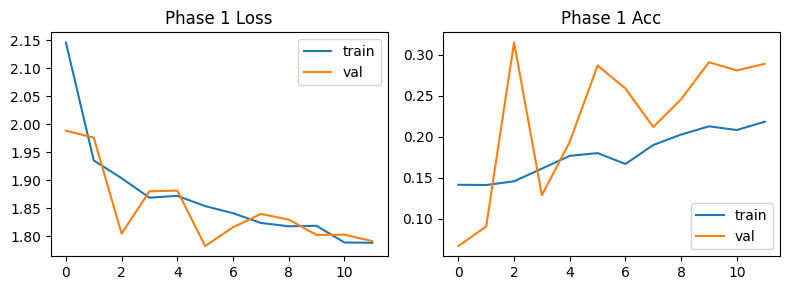

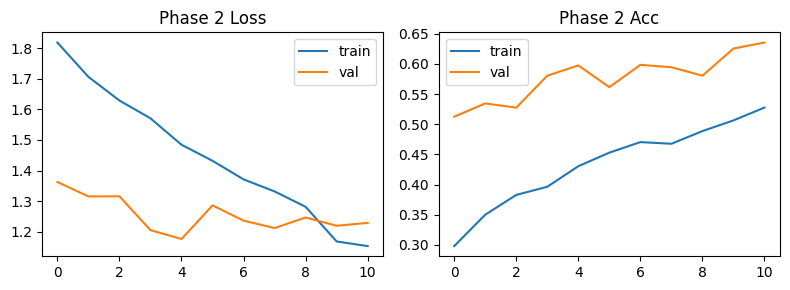

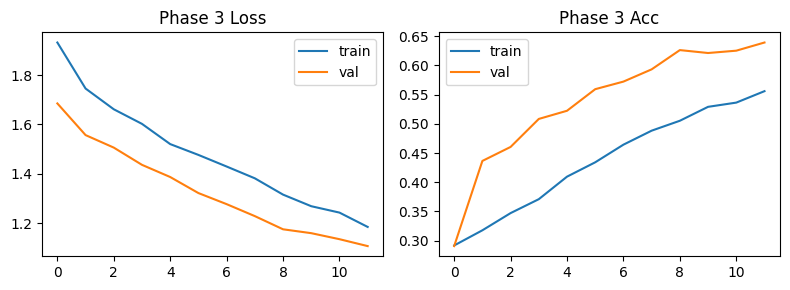


▶ Final test accuracy: 63.07%


In [ ]:
# ── IMPORTS & CONFIG ─────────────────────────────────────────────────────────
import os, numpy as np, tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import (
    ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, CSVLogger
)
from tensorflow.keras.applications import ResNet50
from sklearn.utils import class_weight
import matplotlib.pyplot as plt

#
# train_df, val_df, test_df: DataFrames with ['image_path','mask_path','dx_int']
IMG_SIZE   = (224,224)
BATCH_SIZE = 32
WORK_DIR   = "transfer_3branch_resnet"
CKPT_DIR   = os.path.join(WORK_DIR,"checkpoints")
os.makedirs(CKPT_DIR, exist_ok=True)

# compute class weights
y = train_df.dx_int.values
w = class_weight.compute_class_weight("balanced",
                                       classes=np.unique(y),
                                       y=y)
CLASS_WEIGHTS = dict(enumerate(w))
AUTOTUNE = tf.data.AUTOTUNE

# ── 1) BUILD DATASETS ────────────────────────────────────────────────────────
def load_resize(p, c):
    i = tf.io.read_file(p)
    i = tf.image.decode_image(i, channels=c, expand_animations=False)
    i = tf.image.resize(i, IMG_SIZE)
    return i/255.0

def make_ds(df, augment=False):
    ds = tf.data.Dataset.from_tensor_slices(
        (df.image_path.values, df.mask_path.values, df.dx_int.values)
    )
    def _prep(rp, mp, lbl):
        rgb  = load_resize(rp,3)
        m0   = load_resize(mp,1)
        mask = tf.cast(m0>0.5, tf.float32)
        mask3= tf.tile(mask,[1,1,3])
        over = rgb * mask
        return (rgb, mask3, over), lbl

    ds = ds.map(_prep, num_parallel_calls=AUTOTUNE)
    if augment:
        def _aug(inputs, lbl):
            r,m,o = inputs
            x = tf.concat([r,m,o], axis=-1)
            x = tf.image.random_flip_left_right(x)
            x = tf.image.random_flip_up_down(x)
            x = tf.image.random_brightness(x, 0.1)
            r2,m2,o2 = tf.split(x,[3,3,3],axis=-1)
            return (r2,m2,o2), lbl
        ds = ds.map(_aug, num_parallel_calls=AUTOTUNE)

    return ds.shuffle(500).batch(BATCH_SIZE).prefetch(AUTOTUNE)

train_ds = make_ds(train_df, augment=True)
val_ds   = make_ds(val_df,   augment=False)
test_ds  = make_ds(test_df,  augment=False)


# ── 2) MODEL FACTORY ─────────────────────────────────────────────────────────
def build_3branch_resnet(n_classes):
    in_rgb     = layers.Input((*IMG_SIZE,3), name="rgb")
    in_maskrgb = layers.Input((*IMG_SIZE,3), name="maskrgb")
    in_masked  = layers.Input((*IMG_SIZE,3), name="masked")
    base = ResNet50(include_top=False, weights="imagenet", pooling=None)
    base.trainable = False

    # share backbone
    f1 = base(in_rgb)
    f2 = base(in_maskrgb)
    f3 = base(in_masked)

    p1 = layers.GlobalAveragePooling2D()(f1)
    p2 = layers.GlobalAveragePooling2D()(f2)
    p3 = layers.GlobalAveragePooling2D()(f3)
    x  = layers.Concatenate()([p1,p2,p3])

    x  = layers.Dense(512, activation="relu",
                      kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
    x  = layers.Dropout(0.5)(x)
    out= layers.Dense(n_classes, activation="softmax")(x)

    return models.Model([in_rgb,in_maskrgb,in_masked], out,
                        name="3branch_resnet50")

model = build_3branch_resnet(len(np.unique(y)))
model.summary()


# ── 3) THREE-PHASE FINE-TUNING ────────────────────────────────────────────────
def make_cbs(phase):
    return [
      ModelCheckpoint(
          os.path.join(CKPT_DIR,f"phase{phase}.weights.h5"),
          monitor="val_loss", save_best_only=True,
          save_weights_only=True, verbose=1
      ),
      ReduceLROnPlateau("val_loss", factor=0.5, patience=4, verbose=1),
      EarlyStopping("val_loss", patience=6, restore_best_weights=True, verbose=1),
      CSVLogger(os.path.join(WORK_DIR, f"phase{phase}.log.csv"))
    ]

# Phase 1: head only
for l in model.layers:
    l.trainable = l.name.startswith(("dense","dropout"))
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss="sparse_categorical_crossentropy", metrics=["accuracy"])
h1 = model.fit(train_ds, validation_data=val_ds,
               epochs=12, callbacks=make_cbs(1),
               class_weight=CLASS_WEIGHTS, verbose=2)

# Phase 2: unfreeze top ResNet blocks
backbone = model.get_layer("resnet50")
for l in backbone.layers[-30:]:
    l.trainable = True
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss="sparse_categorical_crossentropy", metrics=["accuracy"])
h2 = model.fit(train_ds, validation_data=val_ds,
               epochs=12, callbacks=make_cbs(2),
               class_weight=CLASS_WEIGHTS, verbose=2)

# Phase 3: unfreeze all
for l in backbone.layers:
    l.trainable = True
model.compile(optimizer=tf.keras.optimizers.Adam(1e-6),
              loss="sparse_categorical_crossentropy", metrics=["accuracy"])
h3 = model.fit(train_ds, validation_data=val_ds,
               epochs=12, callbacks=make_cbs(3),
               class_weight=CLASS_WEIGHTS, verbose=2)


# ── 4) PLOT & EVAL ───────────────────────────────────────────────────────────
def plot_hist(h,p):
    plt.figure(figsize=(8,3))
    plt.subplot(1,2,1)
    plt.plot(h.history["loss"],label="train")
    plt.plot(h.history["val_loss"],label="val")
    plt.title(f"Phase {p} Loss"); plt.legend()
    plt.subplot(1,2,2)
    plt.plot(h.history["accuracy"],label="train")
    plt.plot(h.history["val_accuracy"],label="val")
    plt.title(f"Phase {p} Acc"); plt.legend()
    plt.tight_layout(); plt.show()

plot_hist(h1,1); plot_hist(h2,2); plot_hist(h3,3)

loss, acc = model.evaluate(test_ds, verbose=0)
print(f"\n▶ Final test accuracy: {acc:.2%}")


In [ ]:
# ── 3-BRANCH TRANSFER-LEARNING PIPELINE (RGB + MASK + RGB×MASK) ────────────────

import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.callbacks import (
    ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, CSVLogger
)
from sklearn.utils import class_weight

# — adjust to your environment —
# train_df, val_df, test_df each has columns ['image_path','mask_path','dx_int']
IMG_SIZE   = (224, 224)
BATCH_SIZE = 32
WORK_DIR   = "transfer_3branch"
CKPT_DIR   = os.path.join(WORK_DIR, "checkpoints")
os.makedirs(CKPT_DIR, exist_ok=True)

# ── 1) CLASS WEIGHTS ────────────────────────────────────────────────────────────
y = train_df.dx_int.values
w = class_weight.compute_class_weight("balanced",
                                      classes=np.unique(y),
                                      y=y)
CLASS_WEIGHTS = dict(enumerate(w))
AUTOTUNE = tf.data.AUTOTUNE

# ── 2) DATA LOADER ─────────────────────────────────────────────────────────────
def load_rgb_mask_overlay(img_path, mask_path, label):
    # RGB
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = preprocess_input(tf.cast(img, tf.float32))
    # binary mask → [0,1]
    m = tf.io.read_file(mask_path)
    m = tf.image.decode_png(m, channels=1)
    m = tf.image.resize(m, IMG_SIZE)
    m = tf.cast(m, tf.float32) / 255.0
    m3 = tf.tile(m, [1,1,3])
    # overlay
    ov = img * m3
    return (img, m3, ov), label

def make_ds(df, training=False):
    ds = tf.data.Dataset.from_tensor_slices((
        df.image_path.values,
        df.mask_path.values,
        df.dx_int.values
    ))
    ds = ds.map(load_rgb_mask_overlay, num_parallel_calls=AUTOTUNE)
    if training:
        def aug(x,y):
            i,m,o = x
            i = tf.image.random_flip_left_right(i)
            m = tf.image.random_flip_left_right(m)
            o = tf.image.random_flip_left_right(o)
            return (i,m,o), y
        ds = ds.map(aug, num_parallel_calls=AUTOTUNE)
        ds = ds.shuffle(1000)
    return ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

train_ds = make_ds(train_df, training=True)
val_ds   = make_ds(val_df,   training=False)
test_ds  = make_ds(test_df,  training=False)

# ── 3) MODEL FACTORY ────────────────────────────────────────────────────────────
def build_three_branch_model(n_classes):
    in_rgb  = layers.Input((*IMG_SIZE,3), name="rgb_input")
    in_mask = layers.Input((*IMG_SIZE,3), name="mask_input")
    in_ov   = layers.Input((*IMG_SIZE,3), name="overlay_input")

    # shared backbone
    backbone = ResNet50(
        include_top=False,
        weights="imagenet",
        pooling=None
    )
    backbone.trainable = False

    # reuse it three times
    f1 = backbone(in_rgb)
    f2 = backbone(in_mask)
    f3 = backbone(in_ov)

    p1 = layers.GlobalAveragePooling2D()(f1)
    p2 = layers.GlobalAveragePooling2D()(f2)
    p3 = layers.GlobalAveragePooling2D()(f3)

    x = layers.Concatenate()([p1,p2,p3])
    x = layers.Dense(512,
                     activation="relu",
                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
                     name="dense_head")(x)
    x = layers.Dropout(0.5, name="dropout_head")(x)
    out = layers.Dense(n_classes, activation="softmax", name="pred")(x)

    return models.Model([in_rgb,in_mask,in_ov], out, name="three_branch")

model = build_three_branch_model(len(np.unique(y)))
model.summary()

# ── 4) CALLBACKS ───────────────────────────────────────────────────────────────
def get_cbs(phase):
    return [
        ModelCheckpoint(
            filepath=os.path.join(CKPT_DIR, f"phase{phase}.weights.h5"),
            monitor="val_loss", save_best_only=True,
            save_weights_only=True, verbose=1
        ),
        ReduceLROnPlateau(
            monitor="val_loss", factor=0.5,
            patience=3, verbose=1
        ),
        EarlyStopping(
            monitor="val_loss", patience=5,
            restore_best_weights=True, verbose=1
        ),
        CSVLogger(
            filename=os.path.join(WORK_DIR, f"phase{phase}.log.csv")
        )
    ]

# ── 5) 3-PHASE FINE-TUNING (12 epochs each) ────────────────────────────────────

# Phase 1: head only
for layer in model.layers:
    layer.trainable = False
for layer in model.layers:
    if layer.name in ("dense_head","dropout_head","pred"):
        layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)
h1 = model.fit(
    train_ds, validation_data=val_ds,
    epochs=12, callbacks=get_cbs(1),
    class_weight=CLASS_WEIGHTS, verbose=2
)

# Phase 2: unfreeze last conv5 block
for layer in model.layers:
    if layer.name.startswith("conv5_block") or layer.name in ("dense_head","dropout_head","pred"):
        layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)
h2 = model.fit(
    train_ds, validation_data=val_ds,
    epochs=12, callbacks=get_cbs(2),
    class_weight=CLASS_WEIGHTS, verbose=2
)

# Phase 3: fine-tune everything
for layer in model.layers:
    layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-6),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)
h3 = model.fit(
    train_ds, validation_data=val_ds,
    epochs=12, callbacks=get_cbs(3),
    class_weight=CLASS_WEIGHTS, verbose=2
)

# ── 6) FINAL EVALUATION ────────────────────────────────────────────────────────
loss, acc = model.evaluate(test_ds, verbose=0)
print(f"Three-branch test accuracy: {acc:.2%}")


Model: "three_branch"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ rgb_input           │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mask_input          │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ overlay_input       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ rgb_input[0][0],  │
│ (Functional)        │ 2048)             │            │ mask_input[0][0], │
│                     │                   │            │ overlay_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[1][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[2][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 6144)      │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ global_average_p… │
│                     │                   │            │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_head (Dense)  │ (None, 512)       │  3,146,240 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_head        │ (None, 512)       │          0 │ dense_head[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pred (Dense)        │ (None, 7)         │      3,591 │ dropout_head[0][… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 26,737,543 (102.00 MB)

 Trainable params: 3,149,831 (12.02 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/12

Epoch 1: val_loss improved from inf to 0.98956, saving model to transfer_3branch/checkpoints/phase1.weights.h5
251/251 - 94s - 373ms/step - accuracy: 0.4742 - loss: 1.6376 - val_accuracy: 0.6723 - val_loss: 0.9896 - learning_rate: 1.0000e-04
Epoch 2/12

Epoch 2: val_loss improved from 0.98956 to 0.89028, saving model to transfer_3branch/checkpoints/phase1.weights.h5
251/251 - 29s - 116ms/step - accuracy: 0.6224 - loss: 1.0928 - val_accuracy: 0.7123 - val_loss: 0.8903 - learning_rate: 1.0000e-04
Epoch 3/12

Epoch 3: val_loss did not improve from 0.89028
251/251 - 28s - 113ms/step - accuracy: 0.6548 - loss: 0.9353 - val_accuracy: 0.6074 - val_loss: 1.0716 - learning_rate: 1.0000e-04
Epoch 4/12

Epoch 4: val_loss did not improve from 0.89028
251/251 - 28s - 112ms/step - accuracy: 0.6791 - loss: 0.8575 - val_accuracy: 0.6723 - val_loss: 0.9376 - learning_rate: 1.0000e-04
Epoch 5/12

Epoch 5: val_loss improved from 0.89028 to 0.75563, saving model to transfer_3branch/checkpoints

In [ ]:
#give  3-branch test set its own name:
branch_test_ds = make_three_branch_ds(test_df, training=False)

#baseline scratch CNN
loss_scratch, acc_scratch = scratch_model.evaluate(test_ds, verbose=0)

#3-branch transfer model
loss_branch, acc_branch   = model.evaluate(branch_test_ds, verbose=0)

print(f"Scratch-trained CNN accuracy:    {acc_scratch:.2%}")
print(f"3-branch transfer model accuracy: {acc_branch:.2%}")


Scratch-trained CNN accuracy:    66.97%
3-branch transfer model accuracy: 70.66%


In [ ]:
# %% SAVE ENVIRONMENT SNAPSHOT
!pip freeze | grep -E 'tensorflow|scikit-learn|matplotlib|seaborn|pandas|numpy' > requirements.txt
print("Wrote requirements.txt")


Wrote requirements.txt


In [ ]:
# ═══════════════ Alias for downstream evaluation ════════════════
rgb_model = model        # <-- reuse the trained RGB-only transfer model


In [ ]:
# %% ── LOAD RGB-ONLY MODEL & ALIAS THREE-BRANCH ──────────────────────────
try:
    rgb_model          # already in RAM?
except NameError:
    n_classes = len(label_encoder.classes_)
    rgb_model = build_rgb_model(n_classes)
    rgb_model.load_weights(
        "transfer_rgb_baseline/checkpoints/phase3.weights.h5"  # ← tweak path if needed
    )

# Three-branch model is currently named `model`; keep a clearer handle.
branch_model = model


In [ ]:
# %% ── CREATE y_true FOR ALL METRICS ──────────────────────────────────────
import numpy as np
y_true = np.concatenate([lbl.numpy() for _, lbl in test_ds])
class_names = label_encoder.classes_.tolist()
